# Prepare data input for Amazon Forecast

Forecasting is used in a variety of applications and business use cases: For example, retailers need to forecast the sales of their products to decide how much stock they need by location, Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, Businesses need to estimate their flexible workforce needs, Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and enterprises need to estimate their cloud infrastructure needs.
<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/forecast_overview.png" width="98%">

# Notebook Overview

This notebook provides a template of typical steps required to prepare data input for Amazon Forecast. So, this is part of "Upload your data to Amazon Forecast" in the diagram above.  Your data may need additional Prepare steps and/or you may not need all the steps in this notebook.<br>

You will need lots of customization in the RTS section.  Otherwise, look for following comment string to indicate places you will need to customize this notebook for your data:

In [1]:
####
# EDIT THIS FOR YOUR DATA
####

<b>Step 1 Read data</b>. Modify this section to read your data.

<b>Step 2 Make forecast choices</b>. You need to make some decisions.  How many time units in future do you want to make forecasts?  E.g. if time unit is Hour, then if you want to forecast out 1 week that would be 24*7 = 168 hours.  You'll also be asked if you want integer or float target_values.  And if 0's really mean 0 or are they missing data?

<b>Step 10 Aggregate based on the time granularity of your data.</b> Possible aggregations are minute, hour, day, week, month.  See <a href="https://docs.aws.amazon.com/forecast/latest/dg/howitworks-datasets-groups.html#howitworks-data-alignment" target="_blank">documenatation. </a>

<b>Step 12 Visualization time series and validate the time granularity you chose makes sense.</b>  Too low-granularity means the time series looks like white noise and the data could benefit by aggregation at higher-time-level.  For example, you might start to notice time series cyclical patterns when aggregating historical sales by-hour instead of of by-minute.  Alternate between Step 7 Visualization and Step 5 Aggregation until you are happy with the chosen time-grandularity for your forecasts.

<b>Steps 10 (Aggregate) and 13 (Split train) include a set of common checks on your data for forecasting.</b> One common mistake is customers think they should "try Amazon Forecast with a small sample of data".  If the majority of your time series have fewer than 300 data points, Amazon Forecast will fail, because Amazon Forecast is designed for deep-learning AI forecasting algorithms, which require many data points (typically 1000+) per time series.  Small data is better off using traditional, open-source forecast methods such as ETS (available in Excel), ARIMA, or Prophet.  Small data is not a good fit for Amazon Forecast.  If you really want to try Amazon Forecast, but your data fails the Error Checks consider: 

<ul>
    <li>Can you get more data such that each time series will have longer history with more data points?  If so, return to Step 1.</li>
    <li>Can you combine items into fewer item_ids such that each time series will have longer history with more data points?  If so, return to Step 1.</li>
    <li>Can you reduce forecast dimensions, such as use item_id only and drop location_id?  If so, return to Step 5.</li>
    <li>Can you drop to a lower time-frequency without your data turning into white noise?  Check your data again using Step 10 Aggregate and Step 12 Visualize. </li>
</ul>
 
It may be that you find your data is not a good fit for Amazon Forecast.  In that case, it's better that you discover this early.

<b>In steps 14-20, we will save headerless Target Time Series (TTS), Item metadata (IM), Related Time Series (RTS) to S3</b> so we can trigger Amazon Forecast automation, see
    <a href="https://github.com/aws-samples/amazon-forecast-samples/tree/master/workshops/CloudFormationAutomation" target="_blank">Workshop Instructions Install Automation and Demo</a>

TODO:  bucket steps so list doesn't look so long! <br>
TODO:  Add data normalization step
TODO:  Parallelize all groupby-custom aggregation steps: top-moving and classification calcs...

# Table of Contents 
* Step 0: [Set up and install libraries](#setup)
* Step 1: [Read data](#read)
* Step 2: [Correct dtypes](#fix_dtypes)
* Step 3: [Make forecast choices](#choices)
* Step 4: [Drop null item_ids](#drop_null_items)
* Step 5: [Drop null timestamps](#drop_null_times) 
* Step 7: [Inspect and treat extremes](#treat_extremes) 
* Step 8: [Optional - Round negative targets up to 0](#round_negatives) 
* Step 9: [Optional - Convert negative targets to_nan](#negatives_to_nan) 
* Step 10: [Aggregate at chosen frequency](#groupby_frequency) 
* Step 11: [Typical Retail scenario: Find top-moving items](#top_moving_items)
* Step 12: [Visualize time series](#visualize) 
* Step 13: [Split train/test data](#split_train_test)
* Step 14: [Prepare and save Target Time Series](#TTS) 
* Step 15: [Remove time series with no target values at all](#TTS_remove_all0)
* Step 16: [Remove time series with end of life](#TTS_remove_end_of_life)
* Step 17: [Remove time series with fewer than 5 data points](#TTS_remove_too_few_data_points)
* Step 18: [Optional - Assemble and save TTS_sparse, TTS_dense](#TTS-dense_sparse)
* Step 19: [Optional - Assemble and save TTS_top, TTS_slow](#TTS_top)
* Step 20: [Assemble and save RTS (if any)](#RTS)
* Step 21: [Classify time series](#Classify)
* Step 22: [Optional - Assemble and save TTS_regular, TTS_erratic, TTS_intermittent, TTS_lumpy](#TTS_classes)
* Step 23: [Assemble and save metadata (if any)](#IM) 

## Data used in these notebooks: NYC Taxi trips open data

Given hourly historical taxi trips data for NYC, your task is to predict #pickups in next 7 days, per hour and per pickup zone.  <br>

<ul>
<li>Original data source:  <a href="https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page" target="_blank"> https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</a> </li>
<li>AWS-hosted public source:  <a href="https://registry.opendata.aws/nyc-tlc-trip-records-pds/" target="_blank">https://registry.opendata.aws/nyc-tlc-trip-records-pds/ </a> </li>
<li>AWS managed weather data ingestion as a service that is bundled with Amazon Forecast, aggregated by location and by hour.  Initially only for USA and Europe, but depending on demand, possibly in the future for other global regions. </li>
<li>Data used:  Yellow taxis dates: 2018-12 through 2020-02 to avoid COVID effects </li>
</ul>

 
### Features and cleaning
Note: ~5GB Raw Data has already been cleaned and joined using AWS Glue (tutorials to be created in future). 
<ul>
    <li>Join shape files Latitude, Longitude</li>
    <li>Add Trip duration in minutes</li>
    <li>Drop negative trip distances, 0 fares, 0 passengers, less than 1min trip durations </li>
    <li>Drop 2 unknown zones ['264', '265']
    </ul>

## Step 0:  Set up and install libraries <a class="anchor" id="setup"></a>

In [2]:
# Import standard open libraries
import os
import sys
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import time

print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
# display all rows
pd.set_option('display.max_rows', 1000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import random
import numpy as np
print('numpy: {}'.format(np.__version__))
import matplotlib as mpl
print('matplotlib: {}'.format(mpl.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
print('seaborn: {}'.format(sns.__version__))
# choose colorblind
color_pal = sns.color_palette("colorblind", 6).as_hex()
colorblind6 = ','.join(color_pal).split(",")

# AWS libraries and initialization
import boto3
# # importing forecast notebook utility from notebooks/common directory
# sys.path.insert( 0, os.path.abspath("../../notebooks/common") )
# import util
# import util.fcst_utils

pandas: 1.1.5
numpy: 1.19.5
matplotlib: 3.3.4
seaborn: 0.11.1


In [3]:
#########
# Functions to classify items as "top movers" or not
# TODO: generaize to handle any number of forecast dimensions, not just location
#########

def get_time_min_max(the_df, item_id_col, timestamp_col, location_id_col=None):
    """Calculate min timestamp, max timestamp per item and/or per item-location time series  
       Inputs: pandas dataframe with columns: timestamp, target_value, item_id, location_id (optional)
       Outputs: pandas dataframe with 2 extra columns "min_time" and "max_time"
    """
    df = the_df.copy()
    
    if location_id_col is None:
        # get max
        max_time_df = \
            df.groupby([item_id_col], as_index=False).max()[[item_id_col, timestamp_col]]
        max_time_df.columns = [item_id_col, 'max_time']
        # get min
        min_time_df = df.groupby([item_id_col], as_index=False).min()[[item_id_col, timestamp_col]]
        min_time_df.columns = [item_id_col, 'min_time']
        # merge 2 extra columns per item grouping: max and min
        df = df.merge(right=max_time_df, on=item_id_col)
        df = df.merge(right=min_time_df, on=item_id_col)
        
    else:
        # get max
        max_time_df = \
            df.groupby([item_id_col, location_id_col], as_index=False).max()[[item_id_col, location_id_col, timestamp_col]]
        max_time_df.columns = [item_id_col, location_id_col, 'max_time']
        # get min
        min_time_df = df.groupby([item_id_col, location_id_col], as_index=False).min()[[item_id_col, location_id_col, timestamp_col]]
        min_time_df.columns = [item_id_col, location_id_col, 'min_time']
        # merge 2 extra columns per item grouping: max and min
        df = df.merge(right=max_time_df, on=[item_id_col, location_id_col])
        df = df.merge(right=min_time_df, on=[item_id_col, location_id_col])
        
    return df


def get_velocity_per_item(the_df, timestamp_col, target_value_col, item_id_col, location_id_col=None):
    """Calculate velocity as target_demand per time unit per time series
       Inputs: pandas dataframe with columns: timestamp, target_value, item_id, location_id (optional)
       Outputs: pandas dataframe with extra "velocity" column
    """
    df = the_df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%Y-%m-%d %H:%M:%S')
    
    # append 2 extra columns per time seres: min_time, max_time
    if location_id_col == None:
        df = get_time_min_max(the_df, item_id_col, timestamp_col)
    else:
        df = get_time_min_max(the_df, item_id_col, timestamp_col, location_id_col)
        
#     print (df.sample(10))
    
    # calculate time span per time seres
    df['time_span'] = df['max_time'] - df['min_time']
    df['time_span'] = df['time_span'].apply(lambda x: x.seconds / 3600 + 1) # add 1 to include start datetime and end datetime
    
    # calculate average item demand per time unit
    if location_id_col is None:
        df = df.groupby([item_id_col], as_index=False).agg({'time_span':'mean', target_value_col:'sum'})
    else:
        df = df.groupby([item_id_col, location_id_col], as_index=False).agg({'time_span':'mean', target_value_col:'sum'})
    df['velocity'] = df[target_value_col] / df['time_span']
    
    return df

def get_top_moving_items(the_df
                           , timestamp_col
                           , target_value_col
                           , item_id_col
                           , location_id_col=None):
    """Calculate mean velocity over all items as "criteria".
       Where velocity is demand per time unit per time series
       Assign each item into category "top" or not depending on whether its velocity > criteria.
       Return 4 dataframes:  top_moving and slow_moving items; top_moving and slow_moving time series
    """
    
    # calculate item-level velocity
    df_items_velocity = the_df.copy().reset_index(drop=True)
    df_items_velocity = get_velocity_per_item(df_items_velocity, timestamp_col
                                           , target_value_col, item_id_col)
    # calculate ts-level velocity
    if location_id_col is not None:
        df_ts_velocity = the_df.copy().reset_index(drop=True)
        df_ts_velocity = get_velocity_per_item(df_ts_velocity, timestamp_col
                                               , target_value_col, item_id_col, location_id_col)
    else:
        print("No location found")
        df_ts_velocity = pd.DataFrame()
    
    #########
    # define cut=off criteria for "top-moving" vs "slow-moving" time series
    if location_id_col is None:
        criteria = df_items_velocity['velocity'].mean()
    else:
        criteria = df_ts_velocity['velocity'].mean()
        # define top-moving if velocity > criteria
        df_ts_velocity['top_moving'] = df_ts_velocity['velocity'] > criteria
        print('average velocity of all items:', criteria)
    #########
    
    # define top-moving if velocity > criteria
    df_items_velocity['top_moving'] = df_items_velocity['velocity'] > criteria
    
    return df_items_velocity, df_ts_velocity


#########
# Function to group time series by different time frequency
#########
def aggregate_time_series(theDF, agg_freq, timestamp_col, item_col, target_col, agg_dict, already_grouped):
    """Function that re-groups pandas dataframe by time frequency. Expects a timestamp and item_id column
        as time series dimensions.  If additional columns present, you need to put them in the 
        agg_dict to specify grouping function per additional column.
       Input: 
           theDF = pandas dataframe
           timestamp_col, item_col, target_col = expected column in theDF
           agg_freq = time freq for grouping, can be "Y", "M", "W", "D", "H", "M"
           agg_dict = dictionary of non-key columns w/each column's desired agg fn
                      e.g. agg_dict = {"Qty":"sum", "location_id":"first", ...}
           already_grouped = True if theDF timestamp is already at the desired aggregation level
                               ; False otherwise
    """
    print(f"agg_freq=''{agg_freq}'")
    g = theDF.copy()
    
    if not already_grouped:
        # aggregate by agg_freq
        g = g.groupby([pd.Grouper(key=timestamp_col, freq=agg_freq), item_col]).agg(agg_dict)
        g.drop_duplicates(inplace=True)

        g.reset_index(inplace=True)
        print(f"grouped shape = {g.shape}, original shape = {theDF.shape}")
        display(g.sample(5))
    else:
        print("already grouped")

    # INSPECT DISTRIBUTION OF TIME SERIES LENGTH
    # In chart below, you want bulk of distribution to sit after 300-mark on x-axis.
    # If bulk of distribution is bunched closer to 0, choose smaller time granularity or aggregate item-level only

    # num data points per item
    sparsity = g.copy()
    sparsity = sparsity.groupby([item_col]).count()
    sparsity[[target_col]].hist(bins=32);
    plt.title("Count number data points per item");
    plt.suptitle("In chart below, you want bulk of distribution to sit after 300-mark on x-axis.")
    
    dist = sparsity[[target_col]].describe()
    print(dist)
    
    # INSPECT DISTRIBUTION OF TARGET_VALUES
    dist = g[target_col].describe()

    # In chart below, you want to see the shape of a distribution (counts usually negative-binomial)
    # You do not want to see a randomly uniform shape

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("In chart below, you want to see a distribution, usually negative-binomial or gaussian.", y=1.08)
    # plot distribution of target_value itself
    sparsity = g.copy()
    sparsity[[target_col]].hist(ax=axs[0])
    axs[0].set_title(f"Distribution of {target_col} at '{agg_freq}' level", y=1.08);

    # zoom-in plot distribution of target_value itself
    zoomed = g.copy()
    zoomed = zoomed.loc[(zoomed[target_col]< 2*dist['75%']), :].copy()
    zoomed[[target_col]].hist(bins=32, ax=axs[1])
    axs[1].set_title(f"Distribution of {target_col} up to 75% percentile", y=1.08);

    return g


#########
# Function to classify time series
#########

def calc_ADI(g, time_col, item_col, target_col):
    """    
    Calculates class of time series
    Input: g = grouped pandas dataframe already grouped as single time series at a time
    Ouptu: pandas dataframe with 2 extra columns 'ADI' and 'ts_type'
    Rules:
    1. Regular demand (ADI < 1.32 and CV² < 0.49). 
    2. Intermittent demand (ADI >= 1.32 and CV² < 0.49). 
    3. Erratic demand (ADI < 1.32 and CV² >= 0.49). 
    4. Lumpy demand (ADI >= 1.32 and CV² >= 0.49). Unforecastable.
    """
    df = g.copy()
    
    # calculate ADI
    num_periods = df[time_col].nunique()
    num_demands_missing = df[target_col].isna().sum()
    num_demands = num_periods - num_demands_missing
    ADI = num_periods / num_demands
    df['ADI'] = ADI
    
    # calculate CV, coefficient of variation = std of population / mean value of population
    CV = df[target_col].std() / df.loc[(df[target_col]>0), target_col].mean()
    df['CV'] = CV
    
    # apply rules
    df['ts_type'] = 'lumpy'
    if ((ADI < 1.32) & (CV < 0.49)):
        df['ts_type'] = 'regular'
    elif ((ADI >= 1.32) & (CV < 0.49)):
        df['ts_type'] = 'intermittent'     
    elif ((ADI < 1.32) & (CV >= 0.49)):
        df['ts_type'] = 'erratic'  
    elif ((ADI >= 1.32) & (CV >= 0.49)):
        df['ts_type'] = 'lumpy'  
        
    return df


#########
# Function to plot time series
#########

def make_plots(theDF, use_location, sample_series):
    """
    """
    
    # select range to zoom-in on particular time event
    zoomed = theDF.copy()
    
    # separate plot for each time series entry
    num_plots = len(sample_series)
       
    # resize plots smaller if fewer time series to plot
    if num_plots >= 5:    
        fig, axs = plt.subplots(num_plots, 1, figsize=(15, 15), sharex=True)
    elif num_plots > 1:
        fig, axs = plt.subplots(num_plots, 1, figsize=(15, 8), sharex=True)
    else:
        # default at least 2 plots otherwise axs indexing breaks
        fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    # fig.subplots_adjust(hspace=0.5) # pad a little if each x-axis has title
    
    plot_num = 0
    for i in range(num_plots):

        # get item_id, location_id's target value
        if use_location:
            item = sample_series.iloc[i, 0]
            location = sample_series.iloc[i, 1]
            zoomed2 = zoomed.loc[((zoomed[item_id]==item) & (zoomed[location_id]==location)), :].copy()
        else:
            item = sample_series[i]
            zoomed2 = zoomed.loc[((zoomed[item_id]==item)), :].copy()

        # plot only if time series exists
        if zoomed2.shape[0] > 0:

            # plot target_value 
            zoomed2[[target_value]].plot(ax=axs[plot_num])

            # set title for each subplot
            if use_location:
                axs[plot_num].set_title(f"item {item} and location {location}")  
            else:
                axs[plot_num].set_title(f"item {item}")  
            fig.text(0.04, 0.5, 'Monthly quantity', va='center', rotation='vertical')

            # format the x-axis
            axs[plot_num].set_xlabel("Timestamp")  # set x-axis title
            axs[plot_num].xaxis.label.set_visible(False)

            # remove each individual subplot legend
            axs[plot_num].get_legend().remove()

            # format the grid
            axs[plot_num].grid(False)
            axs[plot_num].grid(which='major', axis='x')

            # increment plot counter
            plot_num = plot_num + 1

    plt.plot();

<b>Create a new S3 bucket for this lesson</b>
- The cell below will create a new S3 bucket with name ending in "forecast-demo-taxi"

In [4]:
# create unique S3 bucket for saving your own data

####
# EDIT THIS FOR YOUR DATA
####
region = boto3.Session("s3").region_name
print(f"region = {region}")
account_id = boto3.client('sts').get_caller_identity().get('Account')

# create unique S3 bucket for saving your own data
bucket_name = account_id + '-forecast-demo-taxi'
# TODO - delete this
bucket_name = "christy-forecast"
print(f"bucket_name = {bucket_name}")

# util.create_bucket(bucket_name, region)
    
# create prefix for organizing your new bucket
prefix = "nyc-taxi-trips"
# TODO delete this
prefix = "open-data-analytics-taxi-trips"

print(f"using folder '{prefix}'")

region = us-west-2
bucket_name = christy-forecast
using folder 'open-data-analytics-taxi-trips'


In [5]:
# Connect API sessions
session = boto3.Session(region_name=region) 
s3 = session.client(service_name='s3')
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

In [6]:
# check you can communicate with Forecast APIs
forecast.list_predictors()

{'Predictors': [{'PredictorArn': 'arn:aws:forecast:us-west-2:938097332257:predictor/gautpuri_test_pred',
   'PredictorName': 'gautpuri_test_pred',
   'DatasetGroupArn': 'arn:aws:forecast:us-west-2:938097332257:dataset-group/agrvivek_parts',
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2021, 4, 21, 20, 15, 40, 403000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2021, 4, 21, 20, 47, 14, 499000, tzinfo=tzlocal())},
  {'PredictorArn': 'arn:aws:forecast:us-west-2:938097332257:predictor/nyctaxi_erratic_snap02232020_168H_2021_04_13_03_24_17',
   'PredictorName': 'nyctaxi_erratic_snap02232020_168H_2021_04_13_03_24_17',
   'DatasetGroupArn': 'arn:aws:forecast:us-west-2:938097332257:dataset-group/nyctaxi_erratic_snap02232020_168H',
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2021, 4, 13, 22, 15, 6, 158000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2021, 4, 14, 14, 24, 8, 306000, tzinfo=tzlocal())},
  {'PredictorArn': 'arn:a

<b>Create IAM Role for Forecast</b> <br>
Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. In the sample notebooks, we use the get_or_create_iam_role() utility function to create an IAM role. Please refer to "notebooks/common/util/fcst_utils.py" for implementation.

In [7]:
try:
    from sagemaker import get_execution_role
    role_arn = get_execution_role()
except:
    # Create the role to provide to Amazon Forecast.
    role_name = "ForecastNotebookRole-Basic"
    print(f"Creating Role {role_name} ...")
    role_arn = util.get_or_create_iam_role( role_name = role_name )
    
# echo user inputs without account
print(f"Success! Created role arn = {role_arn.split('/')[1]}")

Success! Created role arn = service-role


## Step 1. Read data <a class="anchor" id="read"></a>

The first thing we're going to do is read the headerless .csv file.  Then we need to identify which columns map to required Amazon Forecast inputs.

<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/nyctaxi_map_fields.png" width="82%">
<br>

<b>In order to use Weather Index, you need a geolocation-type column.</b>  The geolocation-type column connects your locations to geolocations, and can be 5-digit postal code or latitude_longitude.  For more details, see:
<ul>
    <li><a href="https://docs.aws.amazon.com/forecast/latest/dg/weather.html" target="_blank">Link to documentation about geolocations</a></li>
    <li><a href="https://aws.amazon.com/blogs/machine-learning/amazon-forecast-weather-index-automatically-include-local-weather-to-increase-your-forecasting-model-accuracy/" target="_blank">Our Weather blog, which shows UI steps.</a></li>
</ul>

The cell below shows an example reading headerless csv file with lat_lon geolocation column, "pickup_geolocation".  The rest of this notebook writes headerless csv files to be able to use automation.  If you are not planning on using the automation solution, .csv files with headers are allowed.

In [8]:
####
# EDIT THIS FOR YOUR DATA
####

## Read cleaned, joined, featurized data from Glue ETL processing
df_raw = pd.read_csv("s3://amazon-forecast-samples/data_prep_templates/clean_features.csv"
                          , parse_dates=True
                          , header=None
                          , dtype={0:'str'
                                   , 1: 'str'
                                   , 2: 'str'
                                   , 3:'str'
                                   , 4: 'int32'
                                   , 5: 'float64'
                                   , 6: 'str'
                                   , 7: 'str'
                                   , 8: 'str'}
                          , names=['pulocationid', 'pickup_hourly', 'pickup_day_of_week'
                                   , 'day_hour', 'trip_quantity', 'mean_item_loc_weekday'
                                   , 'pickup_geolocation', 'pickup_borough', 'binned_max_item'])

# drop duplicates
print(df_raw.shape)
df_raw.drop_duplicates(inplace=True)

df_raw['pickup_hourly'] = pd.to_datetime(df_raw["pickup_hourly"], format="%Y-%m-%d %H:%M:%S", errors='coerce')
print(df_raw.shape)
print(df_raw.dtypes)
start_time = df_raw.pickup_hourly.min()
end_time = df_raw.pickup_hourly.max()
print(f"Min timestamp = {start_time}")
print(f"Max timestamp = {end_time}")
df_raw.sample(5)

(1507488, 9)
(1507488, 9)
pulocationid                     object
pickup_hourly            datetime64[ns]
pickup_day_of_week               object
day_hour                         object
trip_quantity                     int32
mean_item_loc_weekday           float64
pickup_geolocation               object
pickup_borough                   object
binned_max_item                  object
dtype: object
Min timestamp = 2019-07-01 00:00:00
Max timestamp = 2020-02-29 23:00:00


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
629799,138,2019-09-26 16:00:00,Thursday,Thursday_16,286,238.37769,40.77486739_-73.87280371,Queens,Cat_2
8494,130,2019-12-29 03:00:00,Sunday,Sunday_3,1,2.25465,40.70327388_-73.80034752,Queens,Cat_1
1042365,10,2019-08-27 01:00:00,Tuesday,Tuesday_1,0,3.20251,40.6781247_-73.79166546,Queens,Cat_1
1092107,21,2019-09-12 06:00:00,Thursday,Thursday_6,0,1.17442,40.60204898_-73.98130073,Brooklyn,Cat_1
1043614,141,2019-09-14 06:00:00,Saturday,Saturday_6,47,202.96310,40.76683882_-73.95971268,Manhattan,Cat_2


In [9]:
####
# EDIT THIS FOR YOUR DATA
####

# map expected column names
item_id = "pulocationid"
target_value = "trip_quantity"
timestamp = "pickup_hourly"
location_id = None
geolocation = "pickup_geolocation"

if location_id is None:
    use_location = False
else:
    use_location = True
print(f"use_location = {use_location}")

# specify array of dimensions you'll use for forecasting
if use_location:
    forecast_dims = [timestamp, location_id, item_id]
else:
    forecast_dims = [timestamp, item_id]
print(f"forecast_dims = {forecast_dims}")
dims_except_timestamp = [i for i in forecast_dims if i != timestamp]
print(f"dims_except_timestamp = {dims_except_timestamp}")

use_location = False
forecast_dims = ['pickup_hourly', 'pulocationid']
dims_except_timestamp = ['pulocationid']


In [10]:
original_shape = df_raw.shape 
original_shape

(1507488, 9)

## Step 2. Correct dtypes <a class="anchor" id="fix_dtypes"></a>

In [11]:
####
# EDIT THIS FOR YOUR DATA
####

# # correct dtypes
# df_raw['ReportingMonth'] = pd.to_datetime(df_raw["ReportingMonth"], format="%Y-%m-%d", errors='coerce')
# # Use the new pandas Integer type
# df_raw.ProductGroup3Id = df_raw.ProductGroup3Id.astype('Int64').astype(str)
# # df_raw.ProductGroup3Id = df_raw.ProductGroup3Id.astype('Int64')
print(df_raw.shape)
print(df_raw.dtypes)

# df_raw.sample(5)

(1507488, 9)
pulocationid                     object
pickup_hourly            datetime64[ns]
pickup_day_of_week               object
day_hour                         object
trip_quantity                     int32
mean_item_loc_weekday           float64
pickup_geolocation               object
pickup_borough                   object
binned_max_item                  object
dtype: object


## Step 3. Make forecast choices <a class="anchor" id="choices"></a>

Below, you need to make some choices.  First, you will be asked how you want to treat target values (the values you're forecasting). 
<ol>
    <li><b>Do you want your target values to be floating point numbers or integers?</b>  If you choose floating point numbers, you won't be able to use negative-binomial distribution later in the DeepAR+ algorithm.  If you don't care about that, then just hit enter to accept the default, which is floats. </li>
    <li><b>Decide if you want to round 0's to nulls.</b>  If you believe in your data '0' really means '0', then just hit enter to accept the default of do nothing to 0's.  On the other hand, if you think some of your 0's were missing data instead of actual 0's, then opt-in by typing 'yes' to convert 0's to nulls. </li>
    <li><b>Decide if you want to automatically impute missing categorical fields?</b> If you think you only have a few missing values, you might impute missing values to be the top category.</li>
    <li><b>Decide if you want to replace extreme values with mean?</b>  If you think you only have one or two extreme values it might make sense to replace them. On the other hand, if you have quite a few, that is indication those values are not really extreme.</li>
    <li><b>Do you want to generate future RTS that extends into future?</b>  If you set this to True, all data will be used for Training.  If you set it to False, a hold-out of length Forecast Horizon will be used to alculte RTS.</li>
    <li><b>How many time units do you want to forecast?</b>. For example, if your time unit is Hour, then if you want to forecast out 1 week, that would be 24*7 = 168 hours, so answer = 168. </li>
    <li><b>What is the time granularity for your data?</b>. For example, if your time unit is Hour, answer = "H". </li>
    <li><b>What is the first date you want to forecast?</b>  Training data will be cut short 1 time unit before the desired first forecast snapshot date.  For example, if the granularity of your data is "D" and you want your first forecast to happen on Feb 8, 2019, then the last timestamp for training will be Feb 7, 2019.</li>
    <li><b>Think of a name you want to give this experiment</b>, so all files will have the same names.  You should also use this same name for your Forecast DatasetGroup name, to set yourself up for reproducibility. </li>
    </ol>

In [12]:
# FORECAST SETTINGS
###################
# INSTRUCTIONS: 
# 1. replace occurences "xxx=+FORECAST_LENGTH" with correct dictionary value 
# 2. run this cell 1x, look at suggested "snapshot_date"
# 3. use suggested "snapshot_date", run again.
###################

# do not round target values to integers
target_to_integer = False

# replace 0's with nulls
replace_all_zeroes_with_null = False

# replace extremes with mean of last 3 months
replace_extremes_with_mean = False

# Create RTS with unknown future data
# Note: if you set this to True, all known data will be used for Training
# Note: if you set this to False, a hold-out of length Forecast Horizon will be used to calculate RTS
create_future_RTS_with_unknown_data = False

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|H|30min|15min|10min|5min|1min$ 
FORECAST_FREQ = "W"

# what is your forecast horizon in number time units you've selected?
# e.g. if you're forecasting in hours, how many hours out do you want a forecast?
FORECAST_LENGTH = 1

# What is the first date you want to forecast? 
# Training data will be cut short 1 time unit before the desired first forecast snapshot date
# get snapshot date (date of 1st forecast) as last time minus forecast horizon
AF_freq_to_dateutil_freq = {"Y":"years", "M":"hours", "W":"weeks", "D":"days", "H":"hours"}

####
# EDIT THIS FOR YOUR DATA
####
###################
# INSTRUCTIONS: replace "xxx=FORECAST_LENGTH" with correct dictionary value from above
#               example if FORECAST_FREQ="W" then use "weeks=FORECAST_LENGTH"
###################
end_time_train = df_raw[timestamp].max() - relativedelta(weeks=FORECAST_LENGTH)
snapshot_date = end_time_train.date() + relativedelta(days=1)
print(f"Suggested snapshot date = {snapshot_date}")

# Run entire cell 1x, to view the "Suggested snapshot date"
# Change snapshot date below to match suggested
SNAPSHOT_DATE = datetime.datetime(2020, 2, 23, 0, 0, 0)  

# What name do you want to give this experiment?  
# Be sure to use same name for your Forecast Dataset Group name.
EXPERIMENT_NAME = "nyctaxi_weekly"
DATA_VERSION = 1

# print some validation back to user
print(f"Convert your frequency to python dateutil = {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")
print(f"Forecast horizon = {FORECAST_LENGTH} {AF_freq_to_dateutil_freq[FORECAST_FREQ]}")

AF_freq_to_dateutil_freq = {"Y":"years", "M":"hours", "W":"weeks", "D":"days", "H":"hours"}
####
# EDIT THIS FOR YOUR DATA
####
###################
# INSTRUCTIONS: replace "xxx=+FORECAST_LENGTH" with correct dictionary value from above
#               example if FORECAST_FREQ="W" then use "weeks=+FORECAST_LENGTH"
###################
snapshot_end = SNAPSHOT_DATE + relativedelta(weeks=+FORECAST_LENGTH)
snapshot_end = snapshot_end - relativedelta(hours=1)
print(f"Training data end date = {end_time_train}")
print(f"Forecast start date = {SNAPSHOT_DATE}")
print(f"Forecast end date = {snapshot_end}")
start_time = df_raw[timestamp].min()
end_time = snapshot_end

snapshot_date_monthYear = SNAPSHOT_DATE.strftime("%m%d%Y")
EXPERIMENT_NAME = f"{EXPERIMENT_NAME}_snap{snapshot_date_monthYear}_{FORECAST_LENGTH}{FORECAST_FREQ}"
print(f"Experiment name = {EXPERIMENT_NAME}")

Suggested snapshot date = 2020-02-23
Convert your frequency to python dateutil = weeks
Forecast horizon = 1 weeks
Training data end date = 2020-02-22 23:00:00
Forecast start date = 2020-02-23 00:00:00
Forecast end date = 2020-02-29 23:00:00
Experiment name = nyctaxi_weekly_snap02232020_1W


## Step 4. Drop null item_ids <a class="anchor" id="drop_null_items"></a>

In [13]:
templist = df_raw[item_id].unique()
print(f"Number unique items: {len(templist)}")
print(f"Number nulls: {pd.isnull(templist).sum()}")

if len(templist) < 20:
    print(templist)

Number unique items: 260
Number nulls: 0


In [14]:
## Drop the null item_ids, if any exist
if pd.isnull(templist).sum() > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[item_id].isna()), :].copy()
    print(df_raw.shape)
    print(len(df_raw[item_id].unique()))
else:
    print("No missing item_ids found.")

No missing item_ids found.


## Step 5. Drop null timestamps <a class="anchor" id="drop_null_times"></a>

In [15]:
# check null timestamps
templist = df_raw.loc[(df_raw[timestamp].isna()), :].shape[0]
print(f"Number nulls: {templist}")

if (templist < 10) & (templist > 0) :
    print(df_raw.loc[(df_raw[timestamp].isna()), :])

Number nulls: 0


In [16]:
## Drop the null quantities and dates
if templist > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[timestamp].isna()), :].copy()
    print(df_raw.shape)
    print(df_raw['timestamp'].isna().sum())
else:
    print("No null timestamps found.")

No null timestamps found.


## Step 7. Inspect (and treat) extremes <a class="anchor" id="treat_extremes"></a>

In [17]:
# Decide how many extreme values is considered unusual
MAX_EXTREMES = 10
EXTREME_VALUE = df_raw[target_value].quantile(0.999999)
print(EXTREME_VALUE)

1533.394524011761


In [18]:
# Inspect extremes
templist = df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :].shape[0]
print(f"Number extremes: {templist}")

if (templist < MAX_EXTREMES) & (templist > 0) :
    print(df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), :].set_index([item_id]))


Number extremes: 2
                   pickup_hourly pickup_day_of_week  day_hour  trip_quantity  mean_item_loc_weekday        pickup_geolocation pickup_borough binned_max_item
pulocationid                                                                                                                                                
79           2019-11-03 01:00:00             Sunday  Sunday_1           2085              288.91544  40.72794428_-73.98521412      Manhattan           Cat_4
148          2019-11-03 01:00:00             Sunday  Sunday_1           1710              183.22917  40.71921167_-73.99071836      Manhattan           Cat_4


In [19]:
replace_extremes_with_mean = False

In [20]:
# Replace extreme value with treated median last 6 months value or last 3 months if hourly data
# TODO - generalize this for many extremes...
MONTHS_TO_USE = 3

if replace_extremes_with_mean:

    # calculate median value from last 3 months before the extreme
    keys = df_raw.loc[(df_raw[target_value]>=EXTREME_VALUE), [timestamp, item_id, location_id]].max()
    temp = df_raw.loc[((df_raw[item_id]==keys[item_id]) 
                       & (df_raw[location_id]==keys[location_id])
                       & (df_raw[timestamp]<keys[timestamp])
                       & (df_raw[timestamp]>keys[timestamp] - relativedelta(months=MONTHS_TO_USE))), :] 
    # make sure you've got 6 values if using 6 months
#     assert(temp.shape[0]==MONTHS_TO_USE)
    # calculate median
    replace_extreme = temp[target_value].median() #np.round(temp[target_value].mean(),0)
    print(replace_extreme)
    # visually check if replaced value looks like median target_value
    display(temp)
else:
    print("Do not replace any extreme values.")

Do not replace any extreme values.


<AxesSubplot:xlabel='pickup_hourly'>

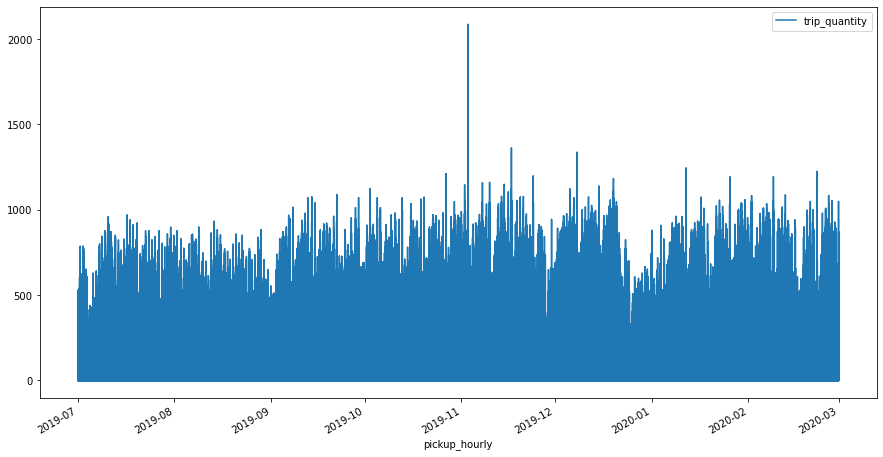

In [21]:
## PLOT OVERALL TIME SERIES - TO HELP INSPECT EXTREMES
df_raw.plot(x=timestamp, y=target_value, figsize=(15, 8))

In [22]:
# Replace extreme value with treated median last 6 months value or last 3 months if hourly data

if (replace_extremes_with_mean & (templist < MAX_EXTREMES)):
    df_clean = df_raw.copy()
    # calculate median
    replace_extreme = temp[target_value].median()
    print(f"replacing extreme value {df_clean.loc[(df_clean[target_value]>=EXTREME_VALUE), target_value].max()} with {replace_extreme}")
    # make the replacement
    df_clean.loc[((df_clean[item_id]==keys[item_id]) 
                       & (df_clean[location_id]==keys[location_id])
                       & (df_clean[timestamp]==keys[timestamp])), target_value] = replace_extreme
    print(f"new value is {df_clean.loc[((df_clean[item_id]==keys[item_id]) & (df_clean[location_id]==keys[location_id]) & (df_clean[timestamp]==keys[timestamp])), target_value].max()}")
    
    # Inspect extremes again on clean data
    EXTREME_VALUE = df_raw[target_value].quantile(0.999999)
    print(EXTREME_VALUE)

    templist = df_clean.loc[(df_clean[target_value]>=EXTREME_VALUE), :].shape[0]
    print(f"Number extremes: {templist}")

    if (templist < MAX_EXTREMES) & (templist > 0) :
        print(df_clean.loc[(df_clean[target_value]>=EXTREME_VALUE), :].set_index([item_id]))
        
    ## PLOT OVERALL TIME SERIES - TO SEE IF YOU DID THE RIGHT THING
    df_clean.plot(x=timestamp, y=target_value, figsize=(15, 8))
else:
    print("No extreme values found or do not replace any extremes.")
    df_clean = df_raw.copy()

No extreme values found or do not replace any extremes.


In [23]:
# save some memory
del df_raw

In [24]:
# throws error if we lost some values
assert original_shape[0] == df_clean.shape[0]

## Step 8. Optional - Round negative targets up to 0 <a class="anchor" id="round_negatives"></a>

In [25]:
# Check negative values
print(df_clean.loc[(df_clean[target_value] <0), :].shape)
df_clean.loc[(df_clean[target_value] <0), :].sort_values([timestamp, item_id]).head()

(0, 9)


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item


In [26]:
# CAREFUL!!  MAKE SURE ROUNDING NEGATIVES UP TO 0 MAKES SENSE FOR YOUR USE CASE

# If negative values found, round them up to 0
if df_clean.loc[(df_clean[target_value] <0), :].shape[0] > 0:

    # Check y-value before cleaning
    print(df_clean[target_value].describe())

    # default negative values in demand to 0
    print(f"{df_clean[target_value].lt(0).sum()} negative values will be rounded up to 0")
    print()
    ts_cols = [target_value]

    for c in ts_cols:
        df_clean.loc[(df_clean[c] < 0.0), c] = 0.0

    # Check y-value after cleaning
    print(df_clean[target_value].describe())
else:
    print("No negative values found.")

No negative values found.


## Step 9. Optional - Convert negative targets to nan <a class="anchor" id="negatives_to_nan"></a>

In [27]:
# # Check negative values
# print(df_clean.loc[(df_clean[target_value] <0), :].shape)
# df_clean.loc[(df_clean[target_value] <0), :].sort_values([timestamp, item_id]).head()

In [28]:
# # # CAREFUL!!  MAKE SURE CHANGING NEGATIVES TO NAN NEGATIVES MAKES SENSE FOR YOUR USE CASE

# # If negative values found, round them up to 0
# if df_clean.loc[(df_clean[target_value] <0), :].shape[0] > 0:

#     # Check y-value before cleaning
#     print(df_clean[target_value].describe())

#     # default negative values in demand to 0
#     print(f"{df_clean[target_value].lt(0).sum()} negative values will be rounded up to 0")
#     print()
#     ts_cols = [target_value]
    
#     print ()

#     for c in ts_cols:
#         df_clean.loc[(df_clean[c] < 0.0), c] = float('nan')
        
        

#     # Check y-value after cleaning
#     print(df_clean[target_value].describe())
# else:
#     print("No negative values found.")

In [29]:
# # throws error if we lost some values
# assert original_shape[0] == df_clean.shape[0]

## Step 10. Aggregate at your chosen frequency <a class="anchor" id="groupby_frequency"></a>

Below, we show an example of resampling at hourly frequency by forecast dimensions.  Modify the code to resample at other frequencies.

Decide which aggregation-level makes sense for your data, which is a balance between desired aggregation and what the data-collection frequency will support.

In [30]:
forecast_dims

['pickup_hourly', 'pulocationid']

In [31]:
## CHECK TO SEE IF YOUR TIMESERIES DIMENSIONS ARE CORRECT

# checking if there are multiple entries per item_id per timestamp per location
df_aux = df_clean.copy().set_index(forecast_dims)

duplicates = df_aux.pivot_table(index=forecast_dims, aggfunc='size')
duplicates = pd.DataFrame( duplicates, columns=["NumberPerTS"])

print (duplicates[duplicates["NumberPerTS"]>1].head())

Empty DataFrame
Columns: [NumberPerTS]
Index: []


In [32]:
# checking to see if your timeseries dimensions are correct
if duplicates[duplicates["NumberPerTS"]>1].shape[0] > 0:
    print("WARNING:  YOUR AGGREGATION ASSUMPTION THAT timestamp, item_id, location_id ARE UNIQUE IS NOT CORRECT.")
    print("Inspect df_aux where you see 'NumberPerTS' > 1")
else:
    print("Success!  timestamp, item_id, location_id is a unique grouping of your time series.")

Success!  timestamp, item_id, location_id is a unique grouping of your time series.


In case your assumed dimensions are not unique, code below is to explore adding a composite column.

In [33]:
# ####
# # EDIT THIS FOR YOUR DATA
# ####

# #  inspect what is happening on these repeated items
# try:
#     df_aux.reset_index(inplace = True)
# except Exception as e:
#     print (e)

# test_aux = df_aux.loc[((df_aux[item_id]=='PRD-05685') & (df_aux[location_id]=='STCK-00605')
#                       & (df_aux[timestamp]=="2019-09-30 01:36:45")), :]
# test_aux.sort_values(by=[timestamp])

# # Possibly extra dimension Organization Name?

In [34]:
# # Since location is not unique, create new fake composite column
# df_clean['timeseries_key'] = df_clean[item_id] + '-'+ df_clean[location_id] \
#                                 + '-' + df_clean['Organization Name']
# df_clean.head(2)

In [35]:
# # If you changed dimensions, re-map expected column names
# item_id = "timeseries_key"
# use_location = False
# forecast_dims = [timestamp, item_id]
# print(f"forecast_dims = {forecast_dims}")
# dims_except_timestamp = [i for i in forecast_dims if i != timestamp]
# print(f"dims_except_timestamp = {dims_except_timestamp}")

In [36]:
# ## CHECK AGAIN TO SEE IF YOUR DATA AGGREGATION ASSUMPTION IS CORRECT

# # checking if there are multiple entries per item_id per timestamp per location
# df_aux = df_clean[forecast_dims + [target_value]].copy().set_index(forecast_dims)
# df_aux.drop_duplicates(inplace=True)

# duplicates = df_aux.pivot_table(index=forecast_dims, aggfunc='size')
# duplicates = pd.DataFrame( duplicates, columns=["NumberPerTS"])

# # checking to see if your data aggregation is correct
# if duplicates[duplicates["NumberPerTS"]>1].shape[0] > 0:
#     print (duplicates[duplicates["NumberPerTS"]>1].head())
#     print("WARNING:  YOUR AGGREGATION ASSUMPTION THAT timestamp, item_id, location_id ARE UNIQUE IS NOT CORRECT.")
#     print("Inspect df_aux where you see 'NumberPerTS' > 1")
# else:
#     print("Success!  timestamp, item_id, location_id is a unique grouping of your time series.")

In [37]:
print(f"forecast_dims = {forecast_dims}")
df_clean.head(1)

forecast_dims = ['pickup_hourly', 'pulocationid']


,pulocationid,pickup_hourly,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
0,1,2019-07-02 09:00:00,Tuesday,Tuesday_9,0,1.00000,40.68951565_-74.17678575,EWR,Cat_1


In [38]:
####
# EDIT THIS FOR YOUR DATA
####

# restrict columns if desired
# df_clean = df_clean[[timestamp, item_id, "Prod #", location_id, "Organization Name", target_value]].copy()
print(df_clean.shape)
df_clean.drop_duplicates(inplace=True)
print(df_clean.shape)

# put all cols besides forecast_dims in a dictionary of agg fns you want to keep in the df
agg_dict = {"pickup_day_of_week":"first", "day_hour":"first"
            ,"trip_quantity":"sum", "mean_item_loc_weekday":"mean", "pickup_geolocation":"first"
            , "pickup_borough":"first", "binned_max_item":"last"}

(1507488, 9)
(1507488, 9)


agg_freq=''W'
grouped shape = (9048, 9), original shape = (1507488, 9)


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
5031,2019-11-17,2,Monday,Monday_1,1,1.04082,40.62572424_-73.82612577,Queens,Cat_1
4549,2019-11-03,230,Monday,Monday_12,54766,303.38352,40.75984474_-73.98417616,Manhattan,Cat_3
8111,2020-02-09,185,Tuesday,Tuesday_13,16,1.05989,40.85347166_-73.85518043,Bronx,Cat_1
3460,2019-10-06,184,Tuesday,Tuesday_8,0,1.07143,40.86478542_-73.80461084,Bronx,Cat_1
7284,2020-01-19,134,Tuesday,Tuesday_9,125,1.44844,40.70875018_-73.8299927,Queens,Cat_1


       trip_quantity
count      260.00000
mean        34.80000
std          1.13831
min         22.00000
25%         35.00000
50%         35.00000
75%         35.00000
max         35.00000


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
3602,2019-10-06,75,Monday,Monday_20,11283,62.15943,40.79065016_-73.94495667,Manhattan,Cat_1
1761,2019-08-18,47,Thursday,Thursday_7,54,1.12301,40.84575495_-73.89692915,Bronx,Cat_1
7773,2020-02-02,113,Thursday,Thursday_7,22993,131.17764,40.73248595_-73.99462822,Manhattan,Cat_1
3360,2019-09-29,9,Friday,Friday_21,16,1.04865,40.75441093_-73.78802025,Queens,Cat_1
813,2019-07-28,131,Wednesday,Wednesday_20,30,1.09765,40.72041233_-73.7713745,Queens,Cat_1


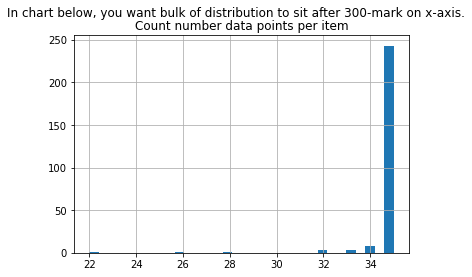

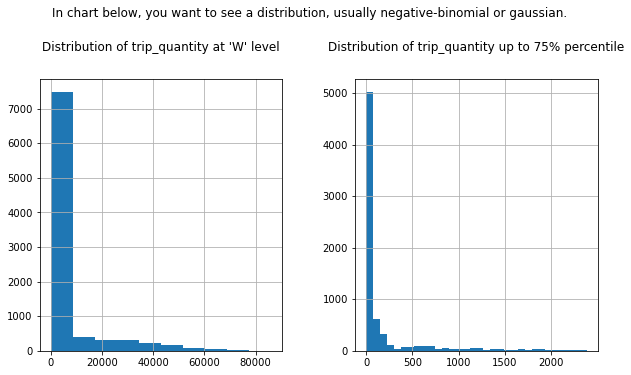

In [39]:
# THIS CODE BLOCK IS AN EXAMPLE OF Weekly AGGREGATION
# def aggregate_time_series(theDF, agg_freq, timestamp_col, item_col, target_col, agg_dict, already_grouped):
#   already_grouped = True if theDF timestamp is already at the desired aggregation level
#                                ; False otherwise
g_week = aggregate_time_series(df_clean, "W", timestamp, item_id, target_value, agg_dict, False)
display(g_week.sample(5))

In [40]:
# # THIS CODE BLOCK IS AN EXAMPLE OF Hourly AGGREGATION
# # Note:  The sample data shipped with notebook is ideal - all time series have 5856 data points, 
# # which is squarely in the Deep Learning desired data size.

# # def aggregate_time_series(theDF, agg_freq, timestamp_col, item_col, target_col, agg_dict, already_grouped):
# #   already_grouped = True if theDF timestamp is already at the desired aggregation level
# #                                ; False otherwise
# g_hour = aggregate_time_series(df_clean, "H", timestamp, item_id, target_value, agg_dict, True)
# display(g_hour.sample(5))

In [41]:
# ## TRY ANOTHER AGGREGATION LEVEL AND COMPARE TARGET_VALUE DISTRIBUTION SHAPES
# agg_freq = "2H"

# g_2hour = aggregate_time_series(df_clean, "2H", timestamp, item_id, target_value, agg_dict, False)
# display(g_2hour.sample(5))

In [42]:
# ## TRY ANOTHER AGGREGATION LEVEL AND COMPARE TARGET_VALUE DISTRIBUTION SHAPES
# agg_freq = "4H"

# g_4hour = aggregate_time_series(df_clean, "4H", timestamp, item_id, target_value, agg_dict, False)
# display(g_4hour.sample(5))

<br>

<b> Select the aggregation-level to keep, based on results above.</b>

In [43]:
# ## USE THE GROUPING YOU SELECTED ABOVE

# df = g_hour.copy()

# # save memory
# del g_hour

# print(df.shape, df_clean.shape)
# df.head(2)

In [44]:
## USE THE GROUPING YOU SELECTED ABOVE

df = g_week.copy()

# save memory
del g_week

print(df.shape, df_clean.shape)
df.sample(5)

(9048, 9) (1507488, 9)


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
7876,2020-02-02,206,Thursday,Thursday_22,0,1.04762,40.6359594_-74.12316376,Staten Island,Cat_1
8491,2020-02-16,6,Tuesday,Tuesday_1,1,1.02192,40.59906217_-74.06777446,Staten Island,Cat_1
2890,2019-09-22,134,Thursday,Thursday_22,107,1.44844,40.70875018_-73.8299927,Queens,Cat_1
6426,2019-12-22,57,Thursday,Thursday_6,0,1.00000,40.75231604_-73.85338447,Queens,Cat_1
6242,2019-12-22,127,Monday,Monday_6,150,1.49849,40.86506268_-73.92032547,Manhattan,Cat_1


## Step 11. Typical retail scenarios: Find top-moving items <a class="anchor" id="top_moving_items"></a>

Next, we want to drill down and visualize some individual item time series.  Typically customers have "catalog-type" data, where only the top 20% of their items are top-movers; the rest of the 80% of items are not top-movers.  For visualization, we want to select automatically some of the top-moving items.

In [45]:
use_location

False

In [46]:
%%time 
## FIND TOP-MOVING ITEMS

if use_location:
    print("using location_id")
    df_velocity, df_ts_velocity = get_top_moving_items(df, timestamp, target_value, item_id, location_id)
else:
    print("using only item_id")
    df_velocity, df_ts_velocity = get_top_moving_items(df, timestamp, target_value, item_id, None)

# Display breakdown: how many top-moving items
if use_location:
    num_top = df_ts_velocity.loc[(df_ts_velocity.top_moving==True), :].groupby(dims_except_timestamp).first().shape[0]
    num_slow = df_ts_velocity.loc[(df_ts_velocity.top_moving==False), :].groupby(dims_except_timestamp).first().shape[0]
    num_time_series = df.groupby(dims_except_timestamp).first().shape[0]
    print(f"number of top moving time series: {num_top}, ratio:{np.round(num_top/num_time_series,2)}")
    print(f"number of slow moving time series: {num_slow}, ratio: {np.round(num_slow/num_time_series,2)}")
    print()
    top_moving_ts = df_ts_velocity.loc[(df_ts_velocity.top_moving==True), :]
    slow_moving_ts = df_ts_velocity.loc[(df_ts_velocity.top_moving==False), :]
    print("Top-moving time series")
    print(top_moving_ts.sort_values('velocity', ascending=False).head(3))
    print()
    print("Slow-moving time series")
    print(slow_moving_ts.sort_values('velocity', ascending=False).head(2))
else:
    num_top = df_velocity.loc[(df_velocity.top_moving==True), item_id].nunique()
    num_slow = df_velocity.loc[(df_velocity.top_moving==False), item_id].nunique()
    num_time_series = df[item_id].nunique()
    print(f"number of top moving items: {num_top}, ratio:{num_top/num_time_series}")
    print(f"number of slow moving items: {num_slow}, ratio: {num_slow/num_time_series}")
    print("Top-moving items")
    top_moving_items = df_velocity.loc[(df_velocity.top_moving==True), :].sort_values('velocity', ascending=False).copy()
    print(top_moving_items.head(3))
    print()
    print("Slow-moving items")
    slow_moving_items = df_velocity.loc[(df_velocity.top_moving==False), :].sort_values('velocity', ascending=False).copy()
    print(slow_moving_items.head(2))


using only item_id
No location found
number of top moving items: 47, ratio:0.18076923076923077
number of slow moving items: 213, ratio: 0.8192307692307692
Top-moving items
    pulocationid  time_span  trip_quantity      velocity  top_moving
150          237    1.00000        2234548 2234548.00000        True
66           161    1.00000        2121595 2121595.00000        True
149          236    1.00000        2005360 2005360.00000        True

Slow-moving items
    pulocationid  time_span  trip_quantity     velocity  top_moving
247           88    1.00000         185184 185184.00000       False
196           41    1.00000         183922 183922.00000       False
CPU times: user 615 ms, sys: 0 ns, total: 615 ms
Wall time: 610 ms


In [47]:
# Instead of completely random items, select top-moving items
if use_location:
    random_series = top_moving_ts.groupby([item_id, location_id])[item_id, location_id].first()
    random_series.reset_index(inplace=True, drop=True)
    random_series = random_series.sample(5)
    print(random_series)
else:
    random_items = top_moving_items[item_id].sample(5)
    random_items = random_items.reset_index()
    random_items = random_items[item_id]
    print(random_items)

0    107
1    163
2    143
3    151
4    100
Name: pulocationid, dtype: object


In [48]:
# # Remove this for your data...

# random_items = list(random_items) + ['79', '135']
# random_items

## Step12. Visualize time series <a class="anchor" id="visualize"></a>

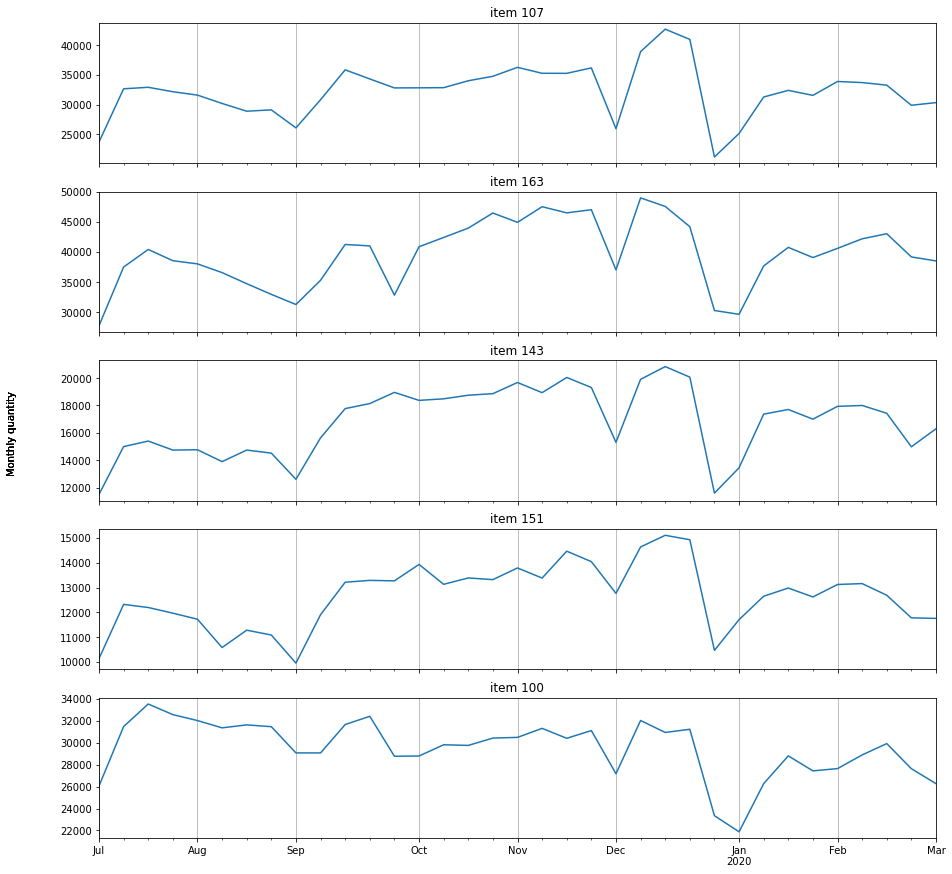

In [49]:
# PREPARE PLOTS OF RANDOM TOP-MOVING ITEMS AND LOCATIONS
# We chose top-moving items to avoid visualizing time series that might be empty or very sparse.

if use_location:
    df_plot = df.loc[(df[item_id].isin(random_series[item_id].unique())
                     & (df[location_id].isin(random_series[location_id].unique())))
                     , [item_id, timestamp, target_value, location_id]].copy()
else:
    df_plot = df.loc[(df[item_id].isin(random_items)), [item_id, timestamp, target_value]].copy()  

df_plot.set_index(timestamp, inplace=True)
df_plot.head(2)


# make plots
if use_location:
    make_plots(df_plot, use_location, random_series)
else:
    make_plots(df_plot, use_location, random_items)
    


## Step 14. Split train/test data  <a class="anchor" id="split_train_test"></a> 

In forecasting, "train" data is until a last-train date, sometimes called the forecast snapshot date.  
<ul>
    <li>Train data includes all data up to your last-train date. </li>
    <li>Test data includes dates after your last-train date through end of desired forecast horizon.</li>
    <li>Validation data might exist for part or maybe all of the desired forecast horizon. </li>
    <li>TTS timestamps should start and end with Train data. </li>
    <li>RTS timestamps should start with Train data and extend out past end of TTS to end of the desired forecast horizon.</li>
    </ul>
    
For model generalization, all processing from here on out will only be done on train data.


TODO:  Adjust this section so you can 1) create RTS with known data, or 2) create RTS with unknown future data.

In [50]:
# Forecast Horizon is number of time steps out in the future you want to predict
# Time steps are defined in the time frequency you specified in Step 5 Aggregate

# Example if aggregation was hourly, then forecast length=168 means forecast horizon of 7 days or 7*24=168 hours
print(f"Forecast horizon = {FORECAST_LENGTH}") # = 12
print(f"Forecast unit of frequency = {AF_freq_to_dateutil_freq[FORECAST_FREQ]}") # = 30
print(f"Forecast start date = {SNAPSHOT_DATE}")

Forecast horizon = 1
Forecast unit of frequency = weeks
Forecast start date = 2020-02-23 00:00:00


In [51]:
# Create train data as all except last FORECAST_HORIZON length
start_time = df[timestamp].min()
end_time = snapshot_end
start_time_test = SNAPSHOT_DATE

print(f"start_time = {start_time}")
print(f"end_time_train = {end_time_train}")
print(f"start_time_test = {start_time_test}")
print(f"end_time = {snapshot_end}")

start_time = 2019-07-07 00:00:00
end_time_train = 2020-02-22 23:00:00
start_time_test = 2020-02-23 00:00:00
end_time = 2020-02-29 23:00:00


In [52]:
create_future_RTS_with_unknown_data

False

In [53]:
if create_future_RTS_with_unknown_data:
    # Create train data as all data => this means RTS will extend into unknown future
    print("using all known data for training")
    train_df = df.copy()
else:
    # Create train subset with hold-out of length FORECAST_LENGTH
    print("using hold-out with train data")
    train_df = df.copy()
    train_df = train_df.loc[(train_df[timestamp] <= end_time_train), :]

# check you did the right thing
print(f"start_time = {start_time}")
print(f"end_time: {end_time}")
print()
print(f"start_time_train = {train_df[timestamp].min()}")
print(f"end_time_train = {train_df[timestamp].max()}")
train_df.head()

using hold-out with train data
start_time = 2019-07-07 00:00:00
end_time: 2020-02-29 23:00:00

start_time_train = 2019-07-07 00:00:00
end_time_train = 2020-02-16 00:00:00


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
0,2019-07-07,1,Tuesday,Tuesday_9,9,1.07192,40.68951565_-74.17678575,EWR,Cat_1
1,2019-07-07,10,Monday,Monday_6,452,3.37108,40.6781247_-73.79166546,Queens,Cat_1
2,2019-07-07,100,Thursday,Thursday_6,26062,176.20120,40.75351409_-73.98878589,Manhattan,Cat_1
3,2019-07-07,101,Wednesday,Wednesday_22,20,1.06928,40.74372178_-73.70907059,Queens,Cat_1
4,2019-07-07,102,Monday,Monday_21,32,1.06014,40.70267936_-73.88199873,Queens,Cat_1


In [54]:
# ERROR CHECK: DO YOU HAVE ENOUGH HISTORICAL DATA POINTS TO SUPPORT DESIRED FORECAST HORIZON?

# calculate number data points in train data
num_data_points = train_df.groupby(dims_except_timestamp).nunique()[timestamp].mean()
print(f"1/3 training data points: {np.round(num_data_points/3,0)}")

# Amazon Forecast length of forecasts can be 500 data points and 1/3 target time series dataset length
if ((FORECAST_LENGTH < 500) & (FORECAST_LENGTH <= np.round(num_data_points/3,0))):
    print(f"Success, forecast horizon {FORECAST_LENGTH} is shorter than 500 data points and 1/3 train data")
else:
    print(f"Error, forecast horizon {FORECAST_LENGTH} is too long.  Need fewer than 500 data points and 1/3 train data. ")
    
# If you have too few data points, return to step above and choose smaller time granularity

1/3 training data points: 11.0
Success, forecast horizon 1 is shorter than 500 data points and 1/3 train data


## Step 15. Prepare and Save Target Time Series (TTS) <a class="anchor" id="TTS"></a>

In [55]:
print(create_future_RTS_with_unknown_data)
train_df.head(1)

False


,pickup_hourly,pulocationid,pickup_day_of_week,day_hour,trip_quantity,mean_item_loc_weekday,pickup_geolocation,pickup_borough,binned_max_item
0,2019-07-07,1,Tuesday,Tuesday_9,9,1.07192,40.68951565_-74.17678575,EWR,Cat_1


<b> TODO:  Customize the dictionary below to map your columns and desired aggregations </b>

In [56]:
## Assemble TTS required columns

####
# EDIT THIS FOR YOUR DATA
####
if geolocation is not None:
    print("running g_else")
    # restrict train data to just tts columns
    tts = train_df[[timestamp, item_id, geolocation, target_value]].copy()
    tts = tts.groupby(forecast_dims)[[target_value, geolocation]].sum()
else:
    print("running else")
    # restrict train data to just tts columns
    tts = train_df[[timestamp, item_id, target_value]].copy()
    tts = tts.groupby(forecast_dims)[[target_value]].sum()
    
tts.reset_index(inplace=True)
print(f"start date = {tts[timestamp].min()}")
print(f"end date = {tts[timestamp].max()}")

# check it
print(tts.shape)
print(tts.dtypes)
tts.head(5)



running g_else
start date = 2019-07-07 00:00:00
end date = 2020-02-16 00:00:00
(8534, 3)
pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object


,pickup_hourly,pulocationid,trip_quantity
0,2019-07-07,1,9
1,2019-07-07,10,452
2,2019-07-07,100,26062
3,2019-07-07,101,20
4,2019-07-07,102,32


In [57]:
# check format of geolocation column
# tts[geolocation].value_counts(normalize=True, dropna=False)

<b>Optional - convert target_value to integer if this is the last step for TTS. </b>

Note: Currently in Amazon Forecast, if you declare target_value is integer in the schema, but you have any decimals in your numbers, you will get an error.

Make sure you really see integers in the code below, if you want integers!

In [58]:
target_to_integer

False

In [59]:
# Use the new pandas Integer type
# https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html
# TODO: turn this into a function

if target_to_integer:
    try:
        tts[target_value] = tts[target_value].astype(int)
        print("Success! Converted to numpy integer")
    except Exception as e:
        print (e)
        print("Trying pandas nullable Integer type instead of numpy integer type...")
        try:
            tts[target_value] = tts[target_value].astype('Int64', errors='ignore')
            print("Success! converted to pandas integer")
        except Exception as e:
            print (e)
elif tts[target_value].dtype == 'object':
    # convert to float
    tts[target_value] = tts[target_value].astype(np.float32)
elif tts[target_value].dtype != 'object':
    # do nothing
    print("target_value is already a float")
    
print(tts.dtypes)
tts.sample(5)

target_value is already a float
pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object


,pickup_hourly,pulocationid,trip_quantity
5477,2019-12-01,133,45
2870,2019-09-22,116,1611
1935,2019-08-25,207,10
3982,2019-10-20,187,0
6786,2020-01-05,150,7


In [60]:
# # Save tts to S3
# local_file = "tts.csv"
# # Save merged file locally
# tts.to_csv(local_file, header=False, index=False)

# key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.csv"
# boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

## Step 16. Remove time series with no target values at all<a class="anchor" id="TTS_remove_all0"></a>
In case there are time series which are only 0's, may as well remove them, since their forecast should be all 0's too.  Another reason to remove these time series is they could bias the overall forecast toward 0, when that's not what you want.

In [61]:
print(dims_except_timestamp)
tts.head(1)

['pulocationid']


,pickup_hourly,pulocationid,trip_quantity
0,2019-07-07,1,9


In [62]:
# check if sum of all sales is 0
g = tts.groupby(item_id).sum()
g.fillna(0, inplace=True)
skus_with_no_sales_in_warehouse = g[g[target_value] == 0].copy()

# drop extra columns for cleaner merge
skus_with_no_sales_in_warehouse.reset_index(inplace=True)
skus_with_no_sales_in_warehouse = skus_with_no_sales_in_warehouse.iloc[:, 0:1]
skus_with_no_sales_in_warehouse.drop_duplicates(inplace=True)
display (skus_with_no_sales_in_warehouse.head(2))

if skus_with_no_sales_in_warehouse.shape[0] > 0:
        
    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_no_sales_in_warehouse, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with only 0's.")

,pulocationid


No time series found with only 0's.


In [63]:
# really drop skus with only 0's

if skus_with_no_sales_in_warehouse.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    skus_with_no_sales_in_warehouse = skus_with_no_sales_in_warehouse[dims_except_timestamp].copy()
    
    # save the reason
    skus_with_no_sales_in_warehouse['reason'] = "All 0's"
    display(skus_with_no_sales_in_warehouse.head(2))
    
    print(tts.shape)
    display(tts.sample(5))

else:
    print("Didn't drop anything")

Didn't drop anything


## Step 17. Remove time series with end of life<a class="anchor" id="TTS_remove_end_of_life"></a>

Check if time series have any data in last 6 months and more than 5 data points, since 5 data points is minimum for Amazon Forecast to generate forecasts.

In [64]:
print(tts.shape)
tts.dtypes

(8534, 3)


pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object

In [65]:
# Define end of life = No sales in the last 6 months

# first get df of only last 6 months
time_threshold = end_time - datetime.timedelta(6*30) 

# check if sum of sales last 6 months is 0
tts_aux = tts[tts[timestamp] >= time_threshold].copy()
g = tts_aux.groupby(dims_except_timestamp).sum()
g.fillna(0, inplace=True)
skus_with_end_of_life = g[g[target_value] == 0].copy()

# drop extra columns for cleaner merge
skus_with_end_of_life.reset_index(inplace=True)
skus_with_end_of_life = skus_with_end_of_life.iloc[:, 0:1]
skus_with_end_of_life.drop_duplicates(inplace=True)
display (skus_with_end_of_life.head(2))

if skus_with_end_of_life.shape[0] > 0:

    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_end_of_life, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with end of life.")

,pulocationid


No time series found with end of life.


In [66]:
# really drop the skus with end of life

if skus_with_end_of_life.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    display(tts.dtypes)
    
    # keep track of dropped dimensions and reason
    skus_with_end_of_life = skus_with_end_of_life[dims_except_timestamp].copy()
    skus_with_end_of_life['reason'] = "end of life"
    display(skus_with_end_of_life.head(2))
    
    print(tts.shape)
    display(tts.sample(5))
    
else:
    print("Didn't drop anything")

Didn't drop anything


## Step 18. Remove time series with fewer than 5 data points<a class="anchor" id="TTS_remove_too_few_data_points"></a>

Note:  Minimum number of data points is 5 data points to make a forecast.  You can run this to remove them manually and save the list of time series with too few data points for your own reference.  Otherwise if you skip this section, Forecast will automatically drop (silently) all time series with fewer than 5 data points, since that is too few to make a good forecast.

In [67]:
print(tts.shape)
tts.sample(5)

(8534, 3)


,pickup_hourly,pulocationid,trip_quantity
7828,2020-02-02,163,40616
6626,2019-12-29,240,2
1248,2019-08-04,53,16
6436,2019-12-22,66,697
4240,2019-10-27,186,57254


<b>Replacing '0's with null</b>

In [68]:
replace_all_zeroes_with_null

False

In [69]:
# # Null-value filling, if any

# special case:  replace 0s with nulls
if (replace_all_zeroes_with_null):
    print(tts.shape)
    print(tts[target_value].describe())
    if target_to_integer:
        tts.loc[(tts[target_value]==0), target_value] = pd.NA
    else:
        tts.loc[(tts[target_value]==0), target_value] = np.nan
    print ()
    print(tts.shape)
    print(tts[target_value].describe())
else:
    tts.loc[:, target_value].fillna(0, inplace=True)
    print("No null-filling required.")

No null-filling required.


In [70]:
# check per time series if count of data points is at least 5
g = tts.groupby(dims_except_timestamp).count()
skus_with_too_few_sales = g[g[target_value] < 5].copy()

# drop extra columns for cleaner merge
skus_with_too_few_sales.reset_index(inplace=True)
skus_with_too_few_sales = skus_with_too_few_sales.iloc[:, 0:1]
skus_with_too_few_sales.drop_duplicates(inplace=True)
display (skus_with_too_few_sales.head(2))

if skus_with_too_few_sales.shape[0] > 0:

    # https://stackoverflow.com/questions/32676027/how-to-do-df1-not-df2-dataframe-merge-in-pandas
    tts_copy = tts.merge(skus_with_too_few_sales, how='left', on=dims_except_timestamp, indicator=True) \
               .query("_merge=='left_only'") \
               .drop('_merge',1)

    print("TTS if you dropped items with too few data points")
    print(tts.shape, tts_copy.shape)
    display(tts_copy.sample(5))

else:
    print("No time series found with fewer than 5 datapoints.")

,pulocationid


No time series found with fewer than 5 datapoints.


In [71]:
# really drop skus with too few data points, only if more than a handful found

if skus_with_too_few_sales.shape[0] > 0:
    print(tts.shape, tts_copy.shape)
    tts = tts_copy.copy()
    del (tts_copy)
    
    # keep track of dropped dimensions and reason why dropped
    skus_with_too_few_sales = skus_with_too_few_sales[dims_except_timestamp].copy()
    skus_with_too_few_sales['reason'] = "Fewer than 5 datapoints"
    display(skus_with_too_few_sales.head(2))
    
    print(tts.shape)
    display(tts.sample(5))
    
else:
    print("Didn't drop anything")

Didn't drop anything


<b> Keep track of dropped time series and reason why they were dropped. </b>

In [72]:
if skus_with_too_few_sales.shape[0] > 0:
    dropped_dims = skus_with_too_few_sales.append([skus_with_no_sales_in_warehouse
                                                       , skus_with_end_of_life])
    print(f"unique ts dropped = {dropped_dims.shape[0]}")
    print(f"unique ts fewer than 5 data points = {skus_with_too_few_sales.shape[0]}")
    print(f"unique ts with all 0s = {skus_with_no_sales_in_warehouse.shape[0]}")
    print(f"unique ts with end of life = {skus_with_end_of_life.shape[0]}")
    display(dropped_dims.reason.value_counts(dropna=False, normalize=True))
    display(dropped_dims.sample(1))
else:
    print("Didn't drop anything")

Didn't drop anything


In [73]:
# save list of dropped skus and reasons for reference and to check if data can be fixed

if skus_with_too_few_sales.shape[0] > 2:
    # save all the dropped dimensions fields
    local_file = "dropped_fields.csv"
    # Save merged file locally
    dropped_dims.to_csv(local_file, header=True, index=False)

    key = f"{prefix}/v{DATA_VERSION}/dropped_{EXPERIMENT_NAME}.csv"
    boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

<b>Optional - convert target_value to integer if this is last step for TTS. </b>

In [74]:
print(tts.shape)
display(tts.dtypes)
tts.head(5)

(8534, 3)


pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object

,pickup_hourly,pulocationid,trip_quantity
0,2019-07-07,1,9
1,2019-07-07,10,452
2,2019-07-07,100,26062
3,2019-07-07,101,20
4,2019-07-07,102,32


In [75]:
target_to_integer

False

In [76]:
# Use the new pandas Integer type
# https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html

if target_to_integer:
    try:
        tts[target_value] = tts[target_value].fillna(0).astype(int)
        print("Success! Converted to np.integer type")
    except Exception as e:
        print (e)
        print("Trying pandas nullable Integer type instead of numpy integer type...")
        try:
            tts[target_value] = tts[target_value].astype('Int64', errors='ignore')
            print("Success! Converted to nullable pd.integer type")
        except Exception as e:
            print (e)
elif tts[target_value].dtype == 'object':
    # convert to float
    tts[target_value] = tts[target_value].astype(np.float32)
elif tts[target_value].dtype != 'object':
    # do nothing
    print("target_value is already a float")
    
print(tts.dtypes)
tts.sample(5)

target_value is already a float
pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object


,pickup_hourly,pulocationid,trip_quantity
3580,2019-10-06,55,34
1421,2019-08-11,211,10510
5383,2019-11-24,46,1
5369,2019-11-24,33,1467
8335,2020-02-16,154,4


<b> Optional - replace 0's with nulls </b>

In [77]:
replace_all_zeroes_with_null

False

In [78]:
if replace_all_zeroes_with_null:
    tts.loc[(tts[target_value]==0), target_value] = pd.NA
    
print(tts[target_value].describe())
print(tts.dtypes)
tts.sample(5)

count    8534.00000
mean     5545.09667
std     13002.46654
min         0.00000
25%        12.00000
50%        46.00000
75%      1198.75000
max     86087.00000
Name: trip_quantity, dtype: float64
pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object


,pickup_hourly,pulocationid,trip_quantity
1380,2019-08-11,175,11
4462,2019-11-03,151,13793
3705,2019-10-13,170,46078
4926,2019-11-17,100,30407
1476,2019-08-11,261,8581


In [79]:
# one last check...
tts = tts[forecast_dims + [target_value]].copy()
print(tts.shape)
tts.drop_duplicates(inplace=True)
print(tts.shape)
print(tts[timestamp].min())
print(tts[timestamp].max())
# check for nulls
print(tts.isnull().sum())
print(tts.dtypes)
tts.sample(5)

(8534, 3)
(8534, 3)
2019-07-07 00:00:00
2020-02-16 00:00:00
pickup_hourly    0
pulocationid     0
trip_quantity    0
dtype: int64
pickup_hourly    datetime64[ns]
pulocationid             object
trip_quantity             int32
dtype: object


,pickup_hourly,pulocationid,trip_quantity
306,2019-07-14,143,14996
387,2019-07-14,216,159
218,2019-07-07,61,315
3272,2019-09-29,247,149
988,2019-07-28,52,648


In [80]:
# Save tts to S3
local_file = "tts.csv"
# Save merged file locally
tts.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [81]:
# Check input numbers of time series
if skus_with_too_few_sales.shape[0] > 0:
    dropped = dropped_dims.groupby(dims_except_timestamp).first().shape[0]
    display(dropped)
    # check
    assert (train_df.groupby(dims_except_timestamp).first().shape[0] \
            == (tts.groupby(dims_except_timestamp).first().shape[0] + dropped))

## Step 19. Optional - Assemble and save TTS_sparse, TTS_dense <a class="anchor" id="TTS-dense_sparse"></a>

In [82]:
forecast_dims
dims_except_timestamp

['pulocationid']

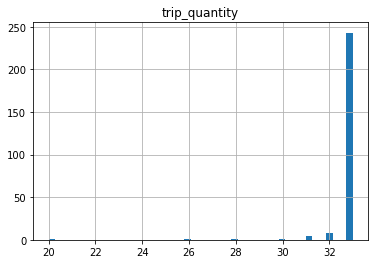

In [83]:
# num data points per item
sparsity = tts.copy()
sparsity = sparsity.groupby(dims_except_timestamp).count()

sparsity[[target_value]].hist(bins=45);

In [84]:
stats = sparsity[target_value].describe()
stats

count   260.00000
mean     32.82308
std       1.02453
min      20.00000
25%      33.00000
50%      33.00000
75%      33.00000
max      33.00000
Name: trip_quantity, dtype: float64

In [85]:
# list the "dense" item combinations
sparsity.reset_index(inplace=True)
dense = sparsity.loc[(sparsity[target_value] >= stats['75%']), forecast_dims].drop_duplicates()
print(dense.shape, sparsity.drop_duplicates().shape)
dense.head()

(243, 2) (260, 3)


,pickup_hourly,pulocationid
0,33,1
1,33,10
2,33,100
3,33,101
4,33,102


In [86]:
# all the rest are sparse
sparse = sparsity.merge(dense, how='outer', indicator=True) \
           .query("_merge=='left_only'") \
           .drop('_merge',1)[forecast_dims]
sparse = sparsity.loc[(sparsity[target_value] < stats['75%']), forecast_dims].drop_duplicates()

print(sparse.shape, dense.shape, sparsity.drop_duplicates().shape)
sparse.head()

(17, 2) (243, 2) (260, 3)


,pickup_hourly,pulocationid
61,32,157
77,32,171
78,31,172
82,28,176
107,26,199


In [87]:
# peek at some singletons
# sparsity.loc[(sparsity[target_value] <5), [item_id, location_id]].drop_duplicates().head()

In [88]:
# # spot-check a singleton
# df.loc[((df[item_id]=="204")), :]

In [89]:
# save sparse dimensions
local_file = "sparse_fields.csv"
# Save merged file locally
sparse.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/sparse_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [90]:
# save dense dimensions
local_file = "dense_fields.csv"
# Save merged file locally
dense.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/dense_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [91]:
# restrict tts to just dense time series
if use_location:
    tts_dense = tts.loc[(tts[item_id].isin(dense[item_id].unique())
                        & (tts[location_id].isin(dense[location_id].unique()))),:].copy()
else:
    tts_dense = tts.loc[(tts[item_id].isin(dense[item_id].unique())),:].copy()
print(tts_dense.shape, tts.shape)
tts_dense.sample(5)

(8019, 3) (8534, 3)


,pickup_hourly,pulocationid,trip_quantity
6187,2019-12-15,75,12179
5003,2019-11-17,173,35
4009,2019-10-20,211,12301
6552,2019-12-29,173,49
2389,2019-09-08,148,19133


## Step 20. Optional - Assemble and save tts.top, tts.slow <a class="anchor" id="TTS_top"></a>

In [92]:
use_location

False

In [93]:
# assemble tts_top
if use_location:
    tts_top = tts.loc[(tts[item_id].isin(top_moving_ts[item_id].unique())
                        & (tts[location_id].isin(top_moving_ts[location_id].unique()))),:].copy()
else:
    tts_top = tts.loc[(tts[item_id].isin(top_moving_items[item_id].unique())),:].copy()

print(tts_top.shape, tts.shape)
num_top_items = tts_top.groupby(dims_except_timestamp).first().shape[0]
print(f"Number top items = {num_top_items}")
tts_top.sample(5)

(1551, 3) (8534, 3)
Number top items = 47


,pickup_hourly,pulocationid,trip_quantity
3397,2019-10-06,125,8036
3438,2019-10-06,162,54653
6362,2019-12-22,236,76966
5513,2019-12-01,166,6550
8291,2020-02-16,114,19268


In [94]:
# Save tts_top to S3
local_file = "tts_top.csv"
# Save merged file locally
tts_top.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_top_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [95]:
# assemble tts_slow
if use_location:
    tts_slow = tts.loc[(tts[item_id].isin(slow_moving_ts[item_id].unique())
                        & (tts[location_id].isin(slow_moving_ts[location_id].unique()))),:].copy()
else:
    tts_slow = tts.loc[(tts[item_id].isin(slow_moving_items[item_id].unique())),:].copy()


print(tts_slow.shape, tts.shape)
num_slow_items = tts_slow.groupby(dims_except_timestamp).first().shape[0]
print(f"Number slow items = {num_slow_items}")
tts_slow.sample(5)

(6983, 3) (8534, 3)
Number slow items = 213


,pickup_hourly,pulocationid,trip_quantity
3109,2019-09-22,96,4
6313,2019-12-22,191,21
4014,2019-10-20,216,112
7399,2020-01-19,240,1
4073,2019-10-20,32,14


In [96]:
# Save tts_slow to S3
local_file = "tts_slow.csv"
# Save merged file locally
tts_slow.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_slow_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

## Step 23. Prepare and save RTS (if any) <a class="anchor" id="RTS"></a>

Make sure RTS does not have any missing values, even if RTS extends into future. <br>
Trick:  create dataframe without any missing values using cross-join, faster than resample technique. <br>

In [97]:
# if you get memory allocation error in merges below, try overriding default value 0 to 1 for overcommit
# see https://www.kernel.org/doc/Documentation/vm/overcommit-accounting
# Might have to do this directly in terminal
# !sudo -i 
# !echo 1 > /proc/sys/vm/overcommit_memory
!cat /proc/sys/vm/overcommit_memory

0


In [98]:
idx = pd.date_range(start=start_time, end=end_time, freq=FORECAST_FREQ)
all_times = pd.DataFrame(index=idx)
print (f"Number of data points: {len(all_times.index)}")
print (f"Start date = {all_times.index.min()}")
print (f"End date = {all_times.index.max()}")

# Create timestamp column
all_times.reset_index(inplace=True)
all_times.columns = [timestamp]

# Create other time-related columns if you need them in RTS
all_times['year_week'] = all_times[timestamp].dt.year.astype(str) + '_' + all_times[timestamp].dt.month.astype(str)

print(all_times.dtypes)
print(all_times.isna().sum())
print(all_times.shape)
all_times.sample(5)

Number of data points: 34
Start date = 2019-07-07 00:00:00
End date = 2020-02-23 00:00:00
pickup_hourly    datetime64[ns]
year_week                object
dtype: object
pickup_hourly    0
year_week        0
dtype: int64
(34, 2)


,pickup_hourly,year_week
9,2019-09-08,2019_9
3,2019-07-28,2019_7
18,2019-11-10,2019_11
2,2019-07-21,2019_7
10,2019-09-15,2019_9


In [99]:
use_location

False

In [100]:
# create master template of all possible locations and items
items = tts.groupby([item_id])[[item_id]].min()
# print(len(items))

if use_location:
    if geolocation is not None:
        print(f"found geolocation {geolocation}")
        locations = pd.DataFrame(list(tts[location_id, geolocation].unique()))
        locations.columns = [location_id, geolocation]
    else:
        locations = pd.DataFrame(list(tts[location_id].unique()))
        locations.columns = [location_id]

    #     print(len(locations))
    locations['key'] = 1
    items['key'] = 1
    # Do the cross-join
    master_records = locations.merge(items, on ='key').drop("key", 1) 
    print(master_records.shape, items.shape, locations.shape)
    num_locs = master_records[location_id].nunique()
    print(f"num locations = {num_locs}")
else:
    master_records = items.copy()
    print(master_records.shape, items.shape)

# check you did the right thing
num_items = master_records[item_id].nunique()
print(f"num items = {num_items}")
master_records.tail()


(260, 1) (260, 1)
num items = 260


,pulocationid
pulocationid,
95,95
96,96
97,97
98,98
99,99


In [101]:
%%time
# cross-join to create master template of all possible locations and items and times
all_times['key'] = "1"
master_records['key'] = "1"
all_times.set_index('key', inplace=True)
master_records.set_index('key', inplace=True)

# Do the cross-join
print("doing the merge...")
full_history = master_records.merge(all_times, how="outer", left_index=True, right_index=True)
print("done w/ merge...")
full_history.reset_index(inplace=True, drop=True)

# make sure you don't have any nulls
print(full_history.shape)
print("checking nulls...")
print(full_history.isna().sum())
full_history.tail()

doing the merge...
done w/ merge...
(8840, 3)
checking nulls...
pulocationid     0
pickup_hourly    0
year_week        0
dtype: int64
CPU times: user 9.41 ms, sys: 398 µs, total: 9.8 ms
Wall time: 8.57 ms


,pulocationid,pickup_hourly,year_week
8835,99,2020-01-26,2020_1
8836,99,2020-02-02,2020_2
8837,99,2020-02-09,2020_2
8838,99,2020-02-16,2020_2
8839,99,2020-02-23,2020_2


In [102]:
# add in original target_value

# small df of target_values
temp_target = df[forecast_dims + [target_value]].copy()
# add key for faster join
if use_location:
    temp_target['ts_key'] = temp_target[timestamp].astype(str) + "-" + temp_target[item_id] + "-" + temp_target[location_id]
else:
    temp_target['ts_key'] = temp_target[timestamp].astype(str) + "-" + temp_target[item_id]
temp_target = temp_target.groupby('ts_key').sum()
# temp_target.drop(forecast_dims, inplace=True, axis=1)
# temp_target.set_index('ts_key', inplace=True)
print(temp_target.shape, df.shape)
display(temp_target.head(2))

(9048, 1) (9048, 9)


,trip_quantity
ts_key,
2019-07-07-1,9
2019-07-07-10,452


In [103]:
# Delete all local files to free up disk space
!rm *.csv

<b> Parallelization for faster merge </b><br>
Below, I used dask.  I also tried ray through modin library.  I found error when adding a new column to modin dataframe.  Maybe by the time you use this notebook the modin/ray problem will be solved.
https://github.com/modin-project/modin/issues/2442

For reference, here are dask best practices:
<ul>
    <li>Choose partitions to be #items if your time series have more dimensions than just item_id, see <a href="https://docs.dask.org/en/latest/best-practices.html" target="_blank">https://docs.dask.org/en/latest/best-practices.html</a></li>
    <li>Make sure reset_index is only done in pandas and not dask, see <a href="https://docs.dask.org/en/latest/dataframe-best-practices.html" target="_blank">https://docs.dask.org/en/latest/dataframe-best-practices.html</a></li>
    </ul>

In [104]:
# dask for faster joins
!pip install "dask[dataframe]" 
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
print('dask: {}'.format(dask.__version__))

dask: 2021.02.0


In [105]:
%%time

# add in original target_value

# USING dask

# large df full_history
temp2 = full_history.copy()

# convert large pandas df to dask df
print(type(temp2))
if use_location:
    num_partitions = num_items
else:
    num_partitions = 1
print(f"using num_partitions = {num_partitions}")
large_df = dd.from_pandas(temp2, npartitions=num_partitions)
print(type(large_df))

# add key for faster join
if use_location:
    large_df['ts_key'] = large_df[timestamp].astype(str) + "-" + large_df[item_id] + "-" + large_df[location_id]
else:
    large_df['ts_key'] = large_df[timestamp].astype(str) + "-" + large_df[item_id]   
print(large_df.shape, full_history.shape)
display(large_df.head(2))

<class 'pandas.core.frame.DataFrame'>
using num_partitions = 1
<class 'dask.dataframe.core.DataFrame'>
(Delayed('int-b5a44401-ef97-43b2-8416-b6dd56f01326'), 4) (8840, 3)


,pulocationid,pickup_hourly,year_week,ts_key
0,1,2019-07-07,2019_7,2019-07-07-1
1,1,2019-07-14,2019_7,2019-07-14-1


CPU times: user 79.9 ms, sys: 9.06 ms, total: 89 ms
Wall time: 90.2 ms


In [106]:
%%time 

# add in original target_value

# temp = pd.concat([temp2.set_index('ts_key'), temp_target.set_index('ts_key')], axis=1)
# temp = pd.concat([temp2, temp_target], keys="ts_key", axis=1)
# drop level, drop null index
# temp.columns = temp.columns.droplevel()
# temp = temp.iloc[:, 1:].copy()
temp = large_df.merge(temp_target, how="left", right_index=True, left_on="ts_key")
print(temp.shape, full_history.shape)
display(temp.head(3))

# CPU times: user 637 ms, sys: 8.18 ms, total: 645 ms
# Wall time: 640 ms

(Delayed('int-1b3abed6-6563-4711-b88c-57c28266b9f5'), 5) (8840, 3)


,pulocationid,pickup_hourly,year_week,ts_key,trip_quantity
0,1,2019-07-07,2019_7,2019-07-07-1,9.00000
1,1,2019-07-14,2019_7,2019-07-14-1,11.00000
2,1,2019-07-21,2019_7,2019-07-21-1,15.00000


CPU times: user 80.9 ms, sys: 153 µs, total: 81 ms
Wall time: 79.8 ms


In [107]:
%%time 

# convert dask df back to pandas df
# # Below is too small !?  rows got dropped, why?
print(type(temp))
temp3 = temp.compute()
print(type(temp3))
temp3.drop('ts_key', axis=1, inplace=True)
print(temp3.shape, full_history.shape)

# check nulls
print(temp3.isna().sum())
display(temp3.sample(3))
temp3[target_value].describe()

<class 'dask.dataframe.core.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(8840, 4) (8840, 3)
pulocationid      0
pickup_hourly     0
year_week         0
trip_quantity    49
dtype: int64


,pulocationid,pickup_hourly,year_week,trip_quantity
8316,85,2019-11-24,2019_11,35.00000
1823,15,2019-12-01,2019_12,6.00000
1929,152,2019-12-29,2019_12,1025.00000


CPU times: user 67.1 ms, sys: 8.84 ms, total: 76 ms
Wall time: 73.1 ms


count    8791.00000
mean     5536.33273
std     12980.91736
min         0.00000
25%        12.00000
50%        46.00000
75%      1194.00000
max     86087.00000
Name: trip_quantity, dtype: float64

In [108]:
# Careful!!
# Really replace full_history with merged values
print(full_history.shape)
full_history = temp3.copy()
print(full_history.shape)
print(type(full_history))
del temp, temp_target, temp2, temp3
full_history.head(2)

(8840, 3)
(8840, 4)
<class 'pandas.core.frame.DataFrame'>


,pulocationid,pickup_hourly,year_week,trip_quantity
0,1,2019-07-07,2019_7,9.00000
1,1,2019-07-14,2019_7,11.00000


In [109]:
####
# EDIT THIS FOR YOUR DATA
####

# Create other time-related columns if you need them in RTS
full_history['month'] = full_history[timestamp].dt.month.astype(str)
full_history['year'] = full_history[timestamp].dt.year.astype(str)
full_history['quarter'] = full_history[timestamp].dt.quarter.astype(str)
full_history['year_month'] = full_history['year'] + '_' + full_history['month']
full_history['year_quarter'] = full_history['year'] + '_' + full_history['quarter']

# # Here are some candidates for hourly data
# full_history['day_of_week'] = full_history[timestamp].dt.day_name().astype(str)
# full_history['hour_of_day'] = full_history[timestamp].dt.hour.astype(str)
# full_history['day_hour_name'] = full_history['day_of_week'] + "_" + full_history['hour_of_day']
# full_history['weekend_flag'] = full_history[timestamp].dt.dayofweek
# full_history['weekend_flag'] = (full_history['weekend_flag'] >= 5).astype(int)
# full_history['is_sun_mon'] = 0
# full_history.loc[((full_history.day_of_week=="Sunday") | (full_history.day_of_week=="Monday")), 'is_sun_mon'] = 1

print(full_history.sample(5))

     pulocationid pickup_hourly year_week  trip_quantity month  year quarter year_month year_quarter
4397          218    2019-09-22    2019_9       32.00000     9  2019       3     2019_9       2019_3
853           124    2019-07-28    2019_7       28.00000     7  2019       3     2019_7       2019_3
8196           82    2019-07-21    2019_7      473.00000     7  2019       3     2019_7       2019_3
6561           38    2020-02-23    2020_2        3.00000     2  2020       1     2020_2       2020_1
3814          202    2019-08-18    2019_8       38.00000     8  2019       3     2019_8       2019_3


In [110]:
# Example - create feature from target_value that is sometimes useful

# # calculate mean sales per item per year
# TODO: add normalization here

# temp_year_item = train_df[['year', item_id, target_value]].copy()
# temp_year_item.year = temp_year_item.year.astype(str)
# temp_year_item = temp_year_item.groupby(['year', item_id]).mean()
# temp_year_item.reset_index(inplace=True)
# temp_year_item.rename(columns={target_value:"count_year_item"}, inplace=True)
# print(temp_year_item.dtypes)
# temp_year_item.sample(2)


In [111]:
# # merge in year-item trend

# temp2 = full_history.copy()
# # temp.drop("count_day_loc_item", inplace=True, axis=1)
# print(temp2.shape)
# temp = temp2.merge(temp_year_item, how="left", on=["year", item_id])
# print(temp.shape, temp_year_item.shape)

# # check nulls
# print(temp.isna().sum())
# temp.sample(5)

In [112]:
# # Careful!!
# # Really replace full_history with merged values
# full_history = temp.copy()
# full_history.head(2)

In [113]:
# zoom-in time slice so you can see patterns
df_plot = full_history.loc[(full_history[item_id].isin(random_items)), :].copy()
print(df_plot.shape, full_history.shape)
df_plot = df_plot.groupby([timestamp]).sum()
df_plot.reset_index(inplace=True)
df_plot.sample(3)

(170, 9) (8840, 9)


,pickup_hourly,trip_quantity
6,2019-08-18,121306.00000
0,2019-07-07,99192.00000
11,2019-09-22,139189.00000


<AxesSubplot:>

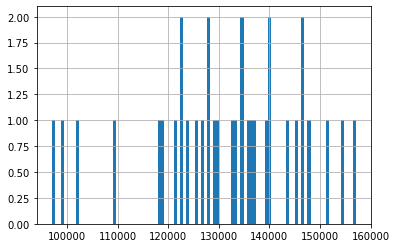

In [114]:
#check: target_value distribution in full dataframe looks same as original
df_plot[target_value].hist(bins=100)

In [115]:
# # EXAMPLE HOURLY RTS

# # Visualize candidate RTS variables
# plt.figure(figsize=(15, 8))
# ax = plt.gca()
# df_plot.plot(x=timestamp, y=target_value, ax=ax);
# ax2 = ax.twinx()
# df_plot.plot(x=timestamp, y='weekend_flag', color='red', alpha=0.3, ax=ax2);

In [116]:
# # EXAMPLE HOURLY RTS

# # Visualize candidate RTS variables is_sun_mon
# plt.figure(figsize=(15, 8))
# ax = plt.gca()
# df_plot.plot(x=timestamp, y=target_value, ax=ax);
# ax2 = ax.twinx()
# df_plot.plot(x=timestamp, y='is_sun_mon', color='red', alpha=0.3, ax=ax2);

In [117]:
# # EXAMPLE HOURLY RTS

# # Zoom-in.  Visualize candidate RTS variables is_sun_mon
# plt.figure(figsize=(15, 8))
# ax = plt.gca()
# df_plot.loc[(df_plot[timestamp]>"2020-02-15"), :].plot(x=timestamp, y=target_value, ax=ax);
# ax2 = ax.twinx()
# df_plot.loc[(df_plot[timestamp]>"2020-02-15"), :].plot(x=timestamp, y='is_sun_mon', color='red', alpha=0.3, ax=ax2);

It looks like lowest taxis rides are wee hours of Sunday morning through Mondays.  So it's a combination of day and hour that seems to matter, not just day of week.

In [118]:
# # EXAMPLE HOURLY RTS

# # Assemble RTS - include whatever columns you finally decide
# rts = full_history[forecast_dims + ['day_hour_name']].copy()

# print(rts.shape)
# print(rts.isnull().sum())
# print(f"rts start: {rts[timestamp].min()}")
# print(f"rts end: {rts[timestamp].max()}")
# rts.sample(5)

In [119]:
# # Save rts to S3
# local_file = "rts.csv"
# # Save merged file locally
# rts.to_csv(local_file, header=False, index=False)

# key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.related.csv"
# boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)


In [120]:
EXPERIMENT_NAME

'nyctaxi_weekly_snap02232020_1W'

In [121]:
DATA_VERSION

1

In [122]:
prefix

'open-data-analytics-taxi-trips'

## Step 13. Classify Time Series <a class="anchor" id="Classify"></a>
Using definitions given here:  https://frepple.com/blog/demand-classification/ and here: https://support.demandcaster.com/hc/en-us/articles/360043259931-Forecast-Structure<br>
Original article:  https://robjhyndman.com/papers/idcat <br>

Idea:  Based on demand patterns, time series can be classified into one of 4 classes:  Regular, Intermittent, Erratic, or Lumpy.  If you have more than 1 class of time series in your data, this might suggest more than 1 model for your time series predictions.  

Rules:
<ol>
    <li><b>Regular</b> demand (ADI < 1.32 and CV² < 0.49). Regular in time and in quantity. It is therefore easy to forecast and you won’t have trouble reaching a low forecasting error level. Suggested algorithm: <b>Traditional statistical such as Exponential Smoothing, Prophet, or ARIMA.</b></li>
    <li><b>Intermittent demand</b> (ADI >= 1.32 and CV² < 0.49). The demand history shows very little variation in demand quantity but a high variation in the interval between two demands. Though specific forecasting methods tackle intermittent demands, the forecast error margin is considerably higher. Suggested algorithm: <b>Croston smoothing or some newer research approach coupled with adjusted error metric over longer time period.</b></li>
    <li><b>Erratic</b> demand (ADI < 1.32 and CV² >= 0.49). The demand has regular occurrences in time with high quantity variations. Your forecast accuracy remains shaky. Suggested algorithm: <b>Deep Learning</b></li>
<li><b>Lumpy</b> demand (ADI >= 1.32 and CV² >= 0.49). The demand is characterized by a large variation in quantity and in time. It is actually impossible to produce a reliable forecast, no matter which forecasting tools you use. This particular type of demand pattern is unforecastable. Suggested algorithm: <b>bootstrap</b></li>
    </ol>


THIS IS JUST A TEST TO CHECK COLOR CHOICES...


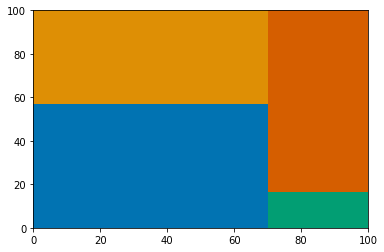

In [123]:
!pip install squarify
import squarify

# SCRATCH - choose 4 colors
print()
print("THIS IS JUST A TEST TO CHECK COLOR CHOICES...")
colors = colorblind6[0:4]
sizes = [40, 30, 5, 25]
squarify.plot(sizes, color=colors)
plt.show();

In [124]:
# %%time
# # For each time series, calculate ADI using pandas apply()
# import warnings
# warnings.filterwarnings('ignore')

# temp = full_history.copy()
# temp = temp.groupby(dims_except_timestamp).apply(lambda x: calc_ADI(x, timestamp, item_id, target_value))

# temp.reset_index(drop=True, inplace=True)
# display(temp.sample(3))

For big data, above is taking too long.  Try dask parallelism instead.<br>
<b>TODO: Customize meta dictionary below according to columns in full_history</b>

In [125]:
full_history.head(1)

,pulocationid,pickup_hourly,year_week,trip_quantity,month,year,quarter,year_month,year_quarter
0,1,2019-07-07,2019_7,9.00000,7,2019,3,2019_7,2019_3


In [126]:
%%time

# convert large pandas df to dask df
print(type(full_history))
if use_location:
    num_partitions = num_items
else:
    num_partitions = 1
print(f"using num_partitions = {num_partitions}")
large_df = dd.from_pandas(full_history, npartitions=num_partitions)
print(type(large_df))

####
# EDIT THIS FOR YOUR DATA
####
# try parallelizing using dask
temp = large_df\
    .groupby([item_id])\
    .apply(lambda x: calc_ADI(x, timestamp, item_id, target_value),
           meta={item_id: "object",
                 timestamp: "object",
                 "year_week": "object", 
                 "trip_quantity": "f4",
                 "month": "object",
                 "year": "object", 
                 "quarter": "object", 
                 "year_month": "object", 
                 "year_quarter": "object", 
                 "ADI": "f4", 
                 "CV": "f4", 
                 "ts_type": "f4"})

<class 'pandas.core.frame.DataFrame'>
using num_partitions = 1
<class 'dask.dataframe.core.DataFrame'>
CPU times: user 25.9 ms, sys: 3.4 ms, total: 29.3 ms
Wall time: 27.5 ms


In [127]:
%%time

import warnings
warnings.filterwarnings('ignore')

# convert dask df back to pandas df
temp2 = temp.compute()
del temp
print(type(temp2))
print(temp2.shape, full_history.shape)
temp2.reset_index(drop=True, inplace=True)
display(temp2.sample(3))

<class 'pandas.core.frame.DataFrame'>
(8840, 12) (8840, 9)


,pulocationid,pickup_hourly,year_week,trip_quantity,month,year,quarter,year_month,year_quarter,ADI,CV,ts_type
3229,187,2020-02-23,2020_2,0.00000,2,2020,1,2020_2,2020_1,1.00000,0.60579,erratic
2007,155,2019-07-14,2019_7,56.00000,7,2019,3,2019_7,2019_3,1.00000,0.47382,regular
6164,28,2019-09-15,2019_9,199.00000,9,2019,3,2019_9,2019_3,1.00000,0.12599,regular


CPU times: user 1.2 s, sys: 6 ms, total: 1.2 s
Wall time: 1.2 s


In [128]:
# Capture each time series class counts
ts_counts = temp2.groupby(dims_except_timestamp)[['ts_type']].first()
ts_counts.reset_index(inplace=True)
ts_counts = ts_counts.ts_type.value_counts(dropna=False)
print("TIME SERIES CLASSES: ")
display(ts_counts)
print(f"NUMBER OF DISTINCT CLASSES OF TIME SERIES = {temp2.ts_type.nunique()}")
print(temp2.shape, full_history.shape)

TIME SERIES CLASSES: 


regular         212
erratic          47
intermittent      1
Name: ts_type, dtype: int64

NUMBER OF DISTINCT CLASSES OF TIME SERIES = 3
(8840, 12) (8840, 9)


In [129]:
# Careful!!
# Really replace full_history with class values
full_history = temp2.copy()
del temp2
full_history.head(2)

,pulocationid,pickup_hourly,year_week,trip_quantity,month,year,quarter,year_month,year_quarter,ADI,CV,ts_type
0,1,2019-07-07,2019_7,9.00000,7,2019,3,2019_7,2019_3,1.00000,0.40807,regular
1,1,2019-07-14,2019_7,11.00000,7,2019,3,2019_7,2019_3,1.00000,0.40807,regular


,ts_type,ts_type_count,ts_type_percent
0,regular,212,81.54000
1,erratic,47,18.08000
2,intermittent,1,0.38000


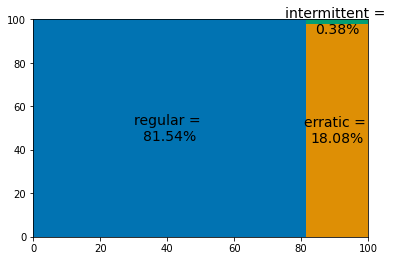

In [130]:
# Plot the time series classes using tree map
ts_classes = pd.DataFrame(ts_counts)
ts_classes.reset_index(inplace=True, drop=False)
ts_classes.columns = ['ts_type', 'ts_type_count']
sum_total = ts_classes['ts_type_count'].sum()
ts_classes['ts_type_percent'] = 100.0 * ts_classes['ts_type_count'] / sum_total
ts_classes['ts_type_percent'] = ts_classes['ts_type_percent'].round(2)
display(ts_classes)

# tree map
lbl = [f"{c[0]} = \n{c[1]}%" for c in zip(ts_classes.ts_type, ts_classes.ts_type_percent)]
squarify.plot(
    label=lbl
    , sizes=list(ts_classes.ts_type_count)
    , color=colors
    , text_kwargs={'fontsize':14});

SHOWING ERRATIC TIME SERIES - SAMPLE(5)


,pulocationid,trip_quantity
pickup_hourly,,
2019-07-07,105,4
2019-07-07,109,1


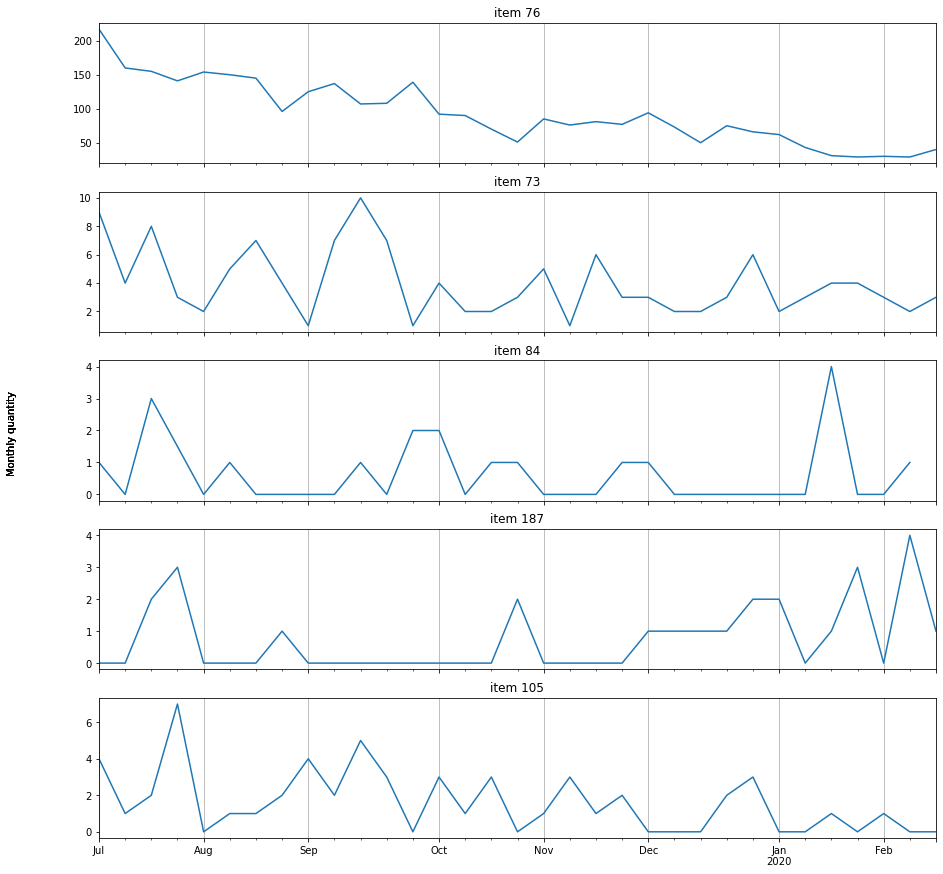

In [131]:
try:
    print("SHOWING ERRATIC TIME SERIES - SAMPLE(5)")
    # visualize some erratic time series
    erratic_sample = full_history.loc[(full_history.ts_type=="erratic"), forecast_dims + [target_value]]
    erratic_items = list(erratic_sample[item_id].unique())
    erratic_sample = tts.loc[(tts[item_id].isin(erratic_items)), :].copy()
    erratic_sample.set_index(timestamp, inplace=True)
    erratic_sample.fillna(0, inplace=True)
    display(erratic_sample.head(2))
    # random sample 5
    erratic_items = erratic_sample[item_id].sample(5)
    # make plots
    make_plots(erratic_sample, False, erratic_items.sample(5))
except:
    print("No erratic time series found.")

SHOWING REGULAR TIME SERIES - SAMPLE(5)


,pulocationid,trip_quantity
pickup_hourly,,
2019-07-07,1,9
2019-07-07,10,452


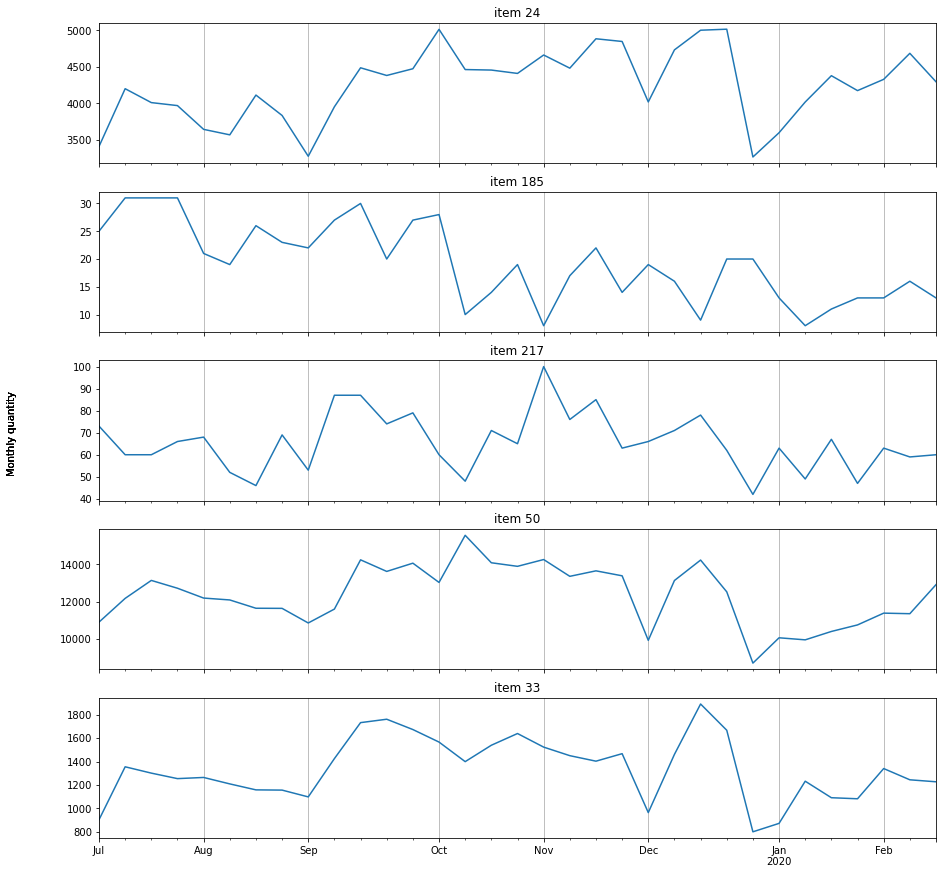

In [132]:
try:
    print("SHOWING REGULAR TIME SERIES - SAMPLE(5)")
    # visualize some regular time series
    regular_sample = full_history.loc[(full_history.ts_type=="regular"), forecast_dims + [target_value]]
    regular_items = list(regular_sample[item_id].unique())
    regular_sample = tts.loc[(tts[item_id].isin(regular_items)), :].copy()
    regular_sample.set_index(timestamp, inplace=True)
    regular_sample.fillna(0, inplace=True)
    display(regular_sample.head(2))
    # random sample 5
    regular_items = regular_sample[item_id].sample(5)
    # make plots
    make_plots(regular_sample, False, regular_items.sample(5))
except:
    print("No regular time series found.")

SHOWING INTERMITTEN TIME SERIES - SAMPLE(5)


,pulocationid,trip_quantity
pickup_hourly,,
2019-07-07,204,0
2019-07-14,204,0


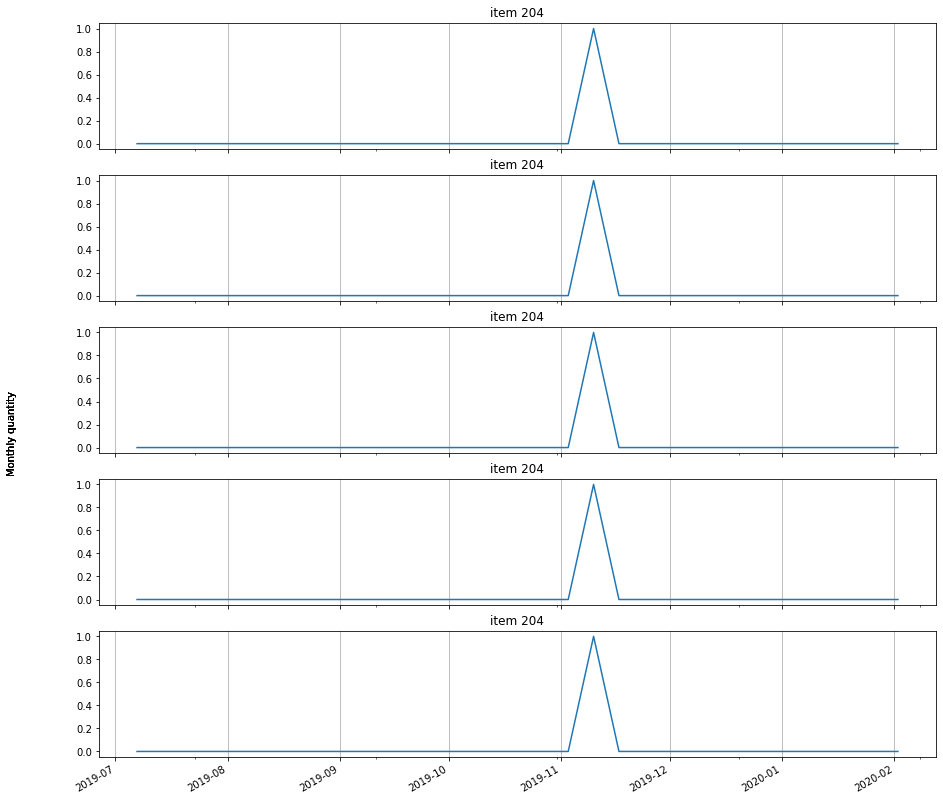

In [133]:
try:
    print("SHOWING INTERMITTEN TIME SERIES - SAMPLE(5)")
    # visualize some intermittent time series
    intermittent_sample = full_history.loc[(full_history.ts_type=="intermittent"), forecast_dims + [target_value]]
    intermittent_items = list(intermittent_sample[item_id].unique())
    intermittent_sample = tts.loc[(tts[item_id].isin(intermittent_items)), :].copy()
    intermittent_sample.set_index(timestamp, inplace=True)
    intermittent_sample.fillna(0, inplace=True)
    display(intermittent_sample.head(2))
    # random sample 5
    intermittent_items = intermittent_sample[item_id].sample(5)
    # make plots
    make_plots(intermittent_sample, False, intermittent_items.sample(5))
except:
    print("No intermittent time series found.")

In [134]:
try:
    print("SHOWING LUMPY TIME SERIES - SAMPLE(5)")
    # visualize some lumpy time series
    lumpy_sample = full_history.loc[(full_history.ts_type=="lumpy"), forecast_dims + [target_value]]
    lumpy_items = list(lumpy_sample[item_id].unique())
#     lumpy_sample = tts.loc[(tts[item_id].isin(lumpy_items)), :].copy()
    lumpy_sample.set_index(timestamp, inplace=True)
    lumpy_sample.fillna(0, inplace=True)
    display(lumpy_sample.head(2))
    # random sample 5
    lumpy_items = lumpy_sample[item_id].sample(5)
    # make plots
    make_plots(lumpy_sample, False, lumpy_items.sample(5))
except:
    print("No lumpy time series found.")

SHOWING LUMPY TIME SERIES - SAMPLE(5)


,pulocationid,trip_quantity
pickup_hourly,,


No lumpy time series found.


## Step 21. Optional - Assemble and save TTS_regular, TTS_erratic, TTS_intermittent, TTS_lumpy <a class="anchor" id="TTS_classes"></a>



In [135]:
# restrict tts to just regular time series
if use_location:
    tts_regular = tts.loc[(tts[item_id].isin(list(regular_sample[item_id, location_id].unique()))), :].copy()
else:
    tts_regular = tts.loc[(tts[item_id].isin(list(regular_sample[item_id].unique()))), :].copy()

print(tts_regular.shape, tts.shape)
num_regular_items = tts_regular[item_id].nunique()
print(f"Number regular items = {num_regular_items}")

if num_regular_items > 0:
    display(tts_regular.sample(5))
else:
    print("No regular time series found.")

(6982, 3) (8534, 3)
Number regular items = 212


,pickup_hourly,pulocationid,trip_quantity
8121,2020-02-09,194,66
6275,2019-12-22,157,105
4922,2019-11-10,98,12
3927,2019-10-20,137,16939
2184,2019-09-01,198,37


In [136]:
# restrict tts to just erratic time series
if use_location:
    tts_erratic = tts.loc[(tts[item_id].isin(list(erratic_sample[item_id, location_id].unique()))), :].copy()
else:
    tts_erratic = tts.loc[(tts[item_id].isin(list(erratic_sample[item_id].unique()))), :].copy()

print(tts_erratic.shape, tts.shape)
num_erratic_items = tts_erratic[item_id].nunique()
print(f"Number erratic items = {num_erratic_items}")

if num_erratic_items > 0:
    display(tts_erratic.sample(5))
else:
    print("No erratic time series found.")

(1532, 3) (8534, 3)
Number erratic items = 47


,pickup_hourly,pulocationid,trip_quantity
3537,2019-10-06,253,3
6347,2019-12-22,222,11
8355,2020-02-16,172,0
1582,2019-08-18,122,10
2203,2019-09-01,214,1


In [137]:
# restrict tts to just intermittent time series
if use_location:
    tts_intermittent = tts.loc[(tts[item_id].isin(list(intermittent_sample[item_id, location_id].unique()))), :].copy()
else:
    tts_intermittent = tts.loc[(tts[item_id].isin(list(intermittent_sample[item_id].unique()))), :].copy()

print(tts_intermittent.shape, tts.shape)
num_intermittent_items = tts_intermittent[item_id].nunique()
print(f"Number intermittent items = {num_intermittent_items}")

if num_intermittent_items > 0:
    display(tts_intermittent.sample(5))
else:
    print("No intermittent time series found.")

(20, 3) (8534, 3)
Number intermittent items = 1


,pickup_hourly,pulocationid,trip_quantity
4261,2019-10-27,204,0
3483,2019-10-06,204,0
7874,2020-02-02,204,0
2192,2019-09-01,204,0
3225,2019-09-29,204,0


In [138]:
# restrict tts to just lumpy time series
if use_location:
    tts_lumpy = tts.loc[(tts[item_id].isin(list(lumpy_sample[item_id, location_id].unique()))), :].copy()
else:
    tts_lumpy = tts.loc[(tts[item_id].isin(list(lumpy_sample[item_id].unique()))), :].copy()

print(tts_lumpy.shape, tts.shape)
num_lumpy_items = tts_lumpy[item_id].nunique()
print(f"Number lumpy items = {num_lumpy_items}")

if num_lumpy_items > 0:
    display(tts_lumpy.sample(5))
else:
    print("No lumpy time series found.")

(0, 3) (8534, 3)
Number lumpy items = 0
No lumpy time series found.


In [139]:
# Save tts_regular to S3
local_file = "tts_regular.csv"
# Save merged file locally
tts_regular.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_regular_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [140]:
# Save tts_erratic to S3
local_file = "tts_erratic.csv"
# Save merged file locally
tts_erratic.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_erratic_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [141]:
# Save tts_intermittent to S3
local_file = "tts_intermittent.csv"
# Save merged file locally
tts_intermittent.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_intermittent_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [142]:
# Save tts_lumpy to S3
local_file = "tts_lumpy.csv"
# Save merged file locally
tts_lumpy.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/tts_lumpy_{EXPERIMENT_NAME}.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)

In [143]:
# check
assert num_regular_items + num_erratic_items + num_intermittent_items + num_lumpy_items == tts[item_id].nunique()

## Step 22. Assemble and save metadata (if any) <a class="anchor" id="IM"></a>

In [144]:
# Identify metadata columns
# im = df[[item_id, 'pickup_borough', 'binned_max_item']].copy()
im = df[[item_id]].copy()
im = im.groupby(dims_except_timestamp).first()
im.reset_index(inplace=True)
# check nulls
display(im.isnull().sum())
im.sample(2)

pulocationid    0
dtype: int64

,pulocationid
245,86
205,5


In [145]:
# Additional metadata created by binning just item target_value is sometimes useful.

# aggregate sales by item 
synthetic = df.copy()
synthetic = (synthetic.groupby(item_id)
        .agg({target_value: ['max']}))

synthetic = synthetic.reset_index()
synthetic.sample(5)

#bin data into 4 categories
cat_scales = ["Cat_{}".format(i) for i in range(1,5)]
synthetic['item_cat_by_max'] = list(pd.cut(synthetic[target_value]['max'].values, 4, labels=cat_scales))

synthetic.drop(target_value, axis=1, inplace=True)
synthetic.columns = synthetic.columns.get_level_values(0)

print(synthetic.shape)
print(synthetic.dtypes)
print(synthetic.columns)
display(synthetic.sample(5))
print(synthetic.item_cat_by_max.value_counts(dropna=False))

# merge synthetic features
im = im.merge(synthetic, how="left", on=[item_id])
print(im.shape, synthetic.shape)
im.head()

(260, 2)
pulocationid       object
item_cat_by_max    object
dtype: object
Index(['pulocationid', 'item_cat_by_max'], dtype='object')


,pulocationid,item_cat_by_max
83,177,Cat_1
45,142,Cat_3
20,12,Cat_1
200,45,Cat_1
133,221,Cat_1


Cat_1    226
Cat_2     19
Cat_3     12
Cat_4      3
Name: item_cat_by_max, dtype: int64
(260, 2) (260, 2)


,pulocationid,item_cat_by_max
0,1,Cat_1
1,10,Cat_1
2,100,Cat_2
3,101,Cat_1
4,102,Cat_1


In [146]:
# check metadata so far

print(im.shape)
if im.shape[0] < 50:
    display(im)
else:
    display(im.head())

# check cardinality of metadata columns
im.describe()

(260, 2)


,pulocationid,item_cat_by_max
0,1,Cat_1
1,10,Cat_1
2,100,Cat_2
3,101,Cat_1
4,102,Cat_1


,pulocationid,item_cat_by_max
count,260,260
unique,260,4
top,106,Cat_1
freq,1,226


In [147]:
# merge in sparse or not column
im['is_sparse'] = 0

im.loc[(im[item_id].isin(list(sparse[item_id].unique()))), 'is_sparse'] = 1
print(im.is_sparse.value_counts(dropna=False))
im.sample(5)

0    243
1     17
Name: is_sparse, dtype: int64


,pulocationid,item_cat_by_max,is_sparse
113,203,Cat_1,0
245,86,Cat_1,0
63,159,Cat_1,0
187,33,Cat_1,0
233,75,Cat_1,0


In [148]:
# merge in top-moving or not column
im['top_moving'] = 0

im.loc[(im[item_id].isin(list(top_moving_items[item_id].unique()))), 'top_moving'] = 1
print(im.top_moving.value_counts(dropna=False))
im.sample(5)

0    213
1     47
Name: top_moving, dtype: int64


,pulocationid,item_cat_by_max,is_sparse,top_moving
234,76,Cat_1,0,0
58,154,Cat_1,0,0
78,172,Cat_1,1,0
143,230,Cat_3,0,1
47,144,Cat_1,0,1


In [149]:
# merge in time series categories column
categories_df = full_history.groupby([item_id])[item_id, 'ts_type'].first()
categories_df.reset_index(inplace=True, drop=True)
# categories_df.head(2)

im = im.merge(categories_df, how="left", on=[item_id])
print(im.ts_type.value_counts(dropna=False))
im.sample(5)

regular         212
erratic          47
intermittent      1
Name: ts_type, dtype: int64


,pulocationid,item_cat_by_max,is_sparse,top_moving,ts_type
48,145,Cat_1,0,0,regular
29,128,Cat_1,0,0,regular
128,217,Cat_1,0,0,regular
184,30,Cat_1,1,0,erratic
178,262,Cat_2,0,1,regular


In [150]:
# Assemble metadata

im = im.groupby(item_id).max()
im.reset_index(inplace=True)
print(im.shape)
print("checking nulls..")
print(im.isnull().sum())
im.sample(5)

(260, 5)
checking nulls..
pulocationid       0
item_cat_by_max    0
is_sparse          0
top_moving         0
ts_type            0
dtype: int64


,pulocationid,item_cat_by_max,is_sparse,top_moving,ts_type
130,219,Cat_1,0,0,regular
162,248,Cat_1,0,0,regular
96,189,Cat_1,0,0,regular
183,3,Cat_1,0,0,regular
24,123,Cat_1,0,0,regular


In [151]:
# Save im to S3
local_file = "tts.csv"
# Save merged file locally
im.to_csv(local_file, header=False, index=False)

key = f"{prefix}/v{DATA_VERSION}/{EXPERIMENT_NAME}.metadata.csv"
boto3.Session().resource('s3').Bucket(bucket_name).Object(key).upload_file(local_file)